## Perform preprocessing

In [59]:
DATA_DIR = "./data"

!kaggle datasets download -d protobioengineering/mit-bih-arrhythmia-database-modern-2023 -p {DATA_DIR} --unzip

Dataset URL: https://www.kaggle.com/datasets/protobioengineering/mit-bih-arrhythmia-database-modern-2023
License(s): CC-BY-SA-4.0




  0%|          | 0.00/231M [00:00<?, ?B/s]
  0%|          | 1.00M/231M [00:00<00:28, 8.48MB/s]
  2%|▏         | 5.00M/231M [00:00<00:09, 25.4MB/s]
  4%|▍         | 10.0M/231M [00:00<00:06, 36.5MB/s]
  6%|▌         | 14.0M/231M [00:00<00:06, 37.7MB/s]
  8%|▊         | 18.0M/231M [00:00<00:06, 34.5MB/s]
 10%|▉         | 22.0M/231M [00:00<00:06, 32.8MB/s]
 11%|█▏        | 26.0M/231M [00:00<00:06, 30.7MB/s]
 15%|█▍        | 34.0M/231M [00:00<00:04, 42.8MB/s]
 17%|█▋        | 40.0M/231M [00:01<00:04, 47.6MB/s]
 20%|█▉        | 46.0M/231M [00:01<00:03, 50.3MB/s]
 23%|██▎       | 52.0M/231M [00:01<00:03, 52.7MB/s]
 25%|██▌       | 58.0M/231M [00:01<00:04, 43.5MB/s]
 27%|██▋       | 63.0M/231M [00:01<00:04, 36.9MB/s]
 29%|██▉       | 67.0M/231M [00:01<00:05, 32.9MB/s]
 33%|███▎      | 76.0M/231M [00:01<00:03, 45.0MB/s]
 35%|███▌      | 81.0M/231M [00:02<00:03, 45.2MB/s]
 38%|███▊      | 87.0M/231M [00:02<00:03, 49.4MB/s]
 41%|████      | 94.0M/231M [00:02<00:02, 51.1MB/s]
 43%|████▎     | 100

In [60]:
import os
import pandas as pd
from collections import defaultdict
from dataclasses import dataclass, field

DATA_DIR = "./data"
SIGNAL = "MLII"

@dataclass
class EkgRecord:
    signal: pd.DataFrame = field(default=None) 
    annotations: pd.DataFrame = field(default_factory=lambda: pd.DataFrame()) 

def read_ekg_file(file_path):
    data = pd.read_csv(file_path)
    if SIGNAL in data.columns:
        return data
    else:
        file_name = file_path.split(os.path.sep)[-1]
        skipped_files.append(file_name)
        return None

def read_annotation_file(file_path):
    data = pd.read_csv(file_path)
    return data

ekg_records = defaultdict(EkgRecord)
file_list = os.listdir(DATA_DIR)
skipped_files = []

print(f"Processing {len(file_list)} files in {DATA_DIR} ...")

for file_name in file_list:
    if not file_name.endswith('.csv') or file_name == 'annotation_symbols.csv':
        continue

    file_path = os.path.join(DATA_DIR, file_name)

    ekg_number = file_name.split('_')[0]
    record = ekg_records[ekg_number]

    if '_ekg.csv' in file_name:
        signal_data = read_ekg_file(file_path)
        if signal_data is not None:
            record.signal = signal_data
        else:
            skipped_files.append(file_name)
    
    elif '_annotations_' in file_name:
        annotation_data = read_annotation_file(file_path)
        if annotation_data is not None:
            record.annotations = pd.concat([record.annotations, annotation_data], ignore_index=True)

for file_name in skipped_files:
    ekg_number = file_name.split('_')[0]
    if ekg_number in ekg_records:
        del ekg_records[ekg_number]


Processing 202 files in ./data ...


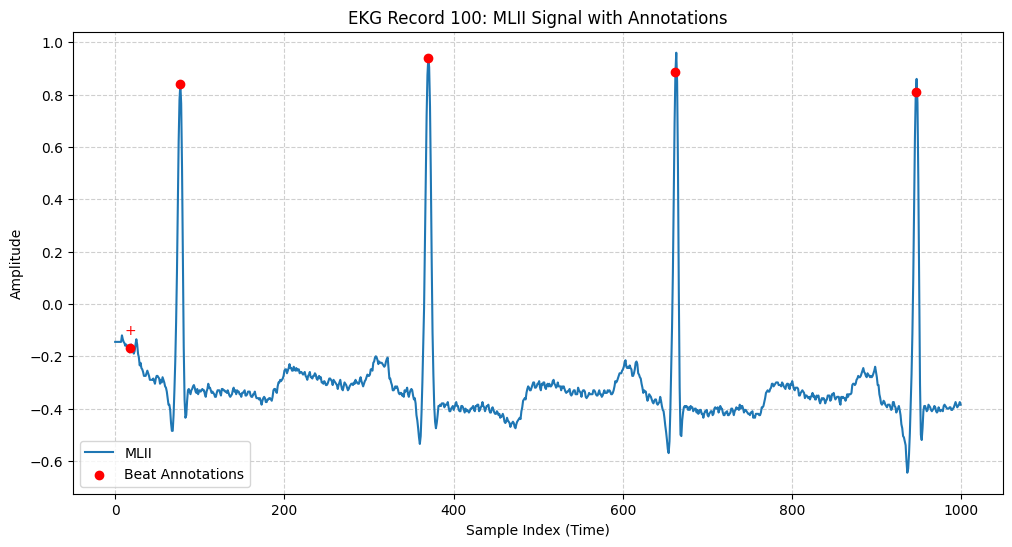

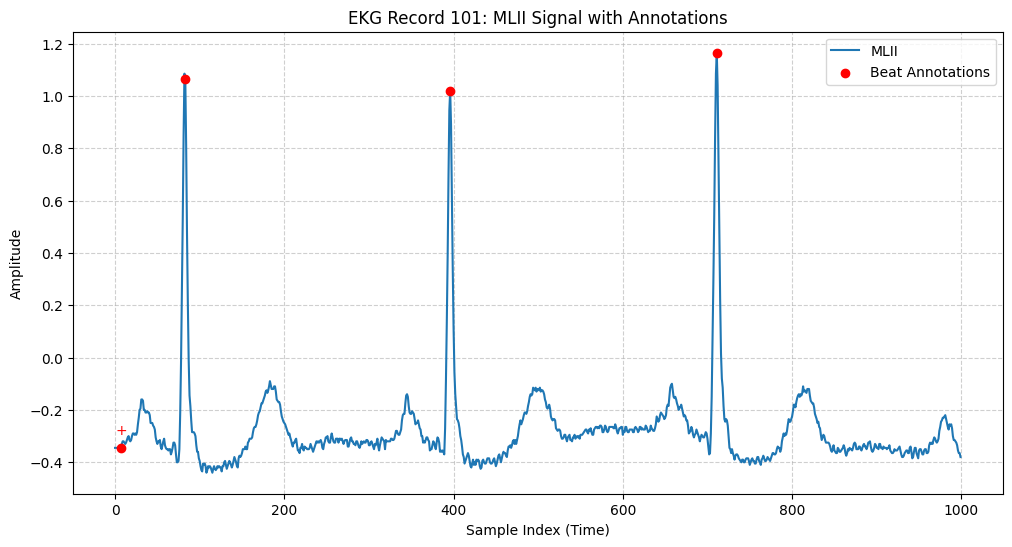

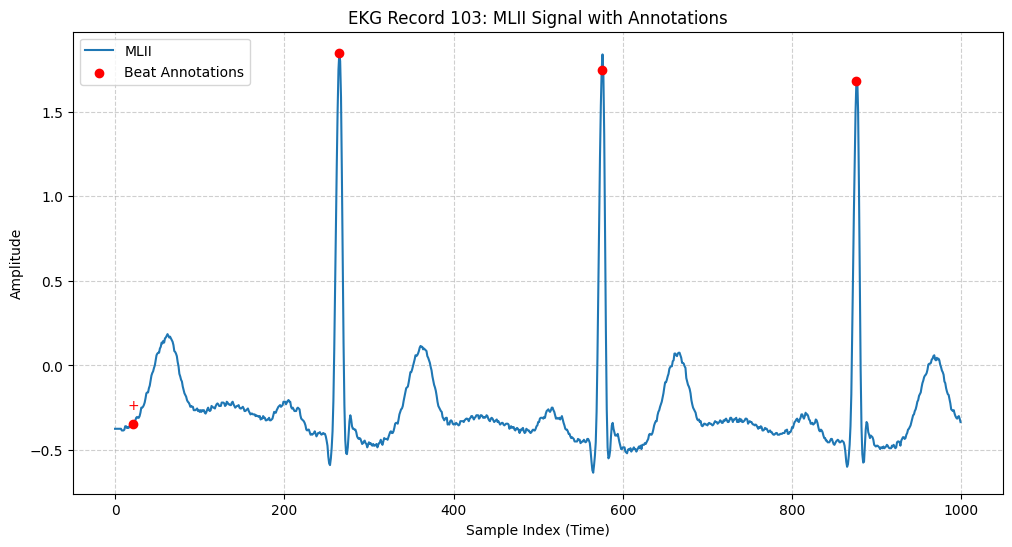

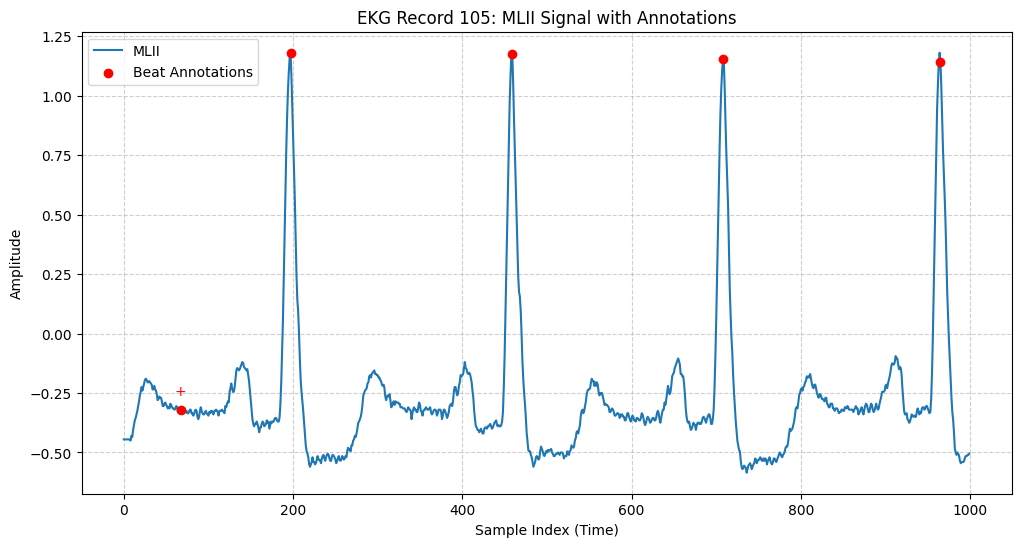

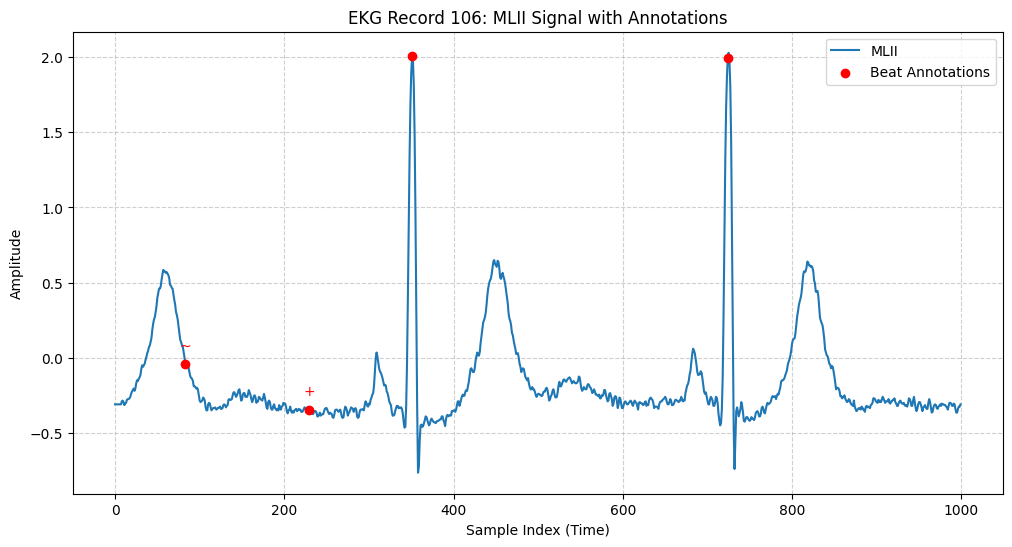

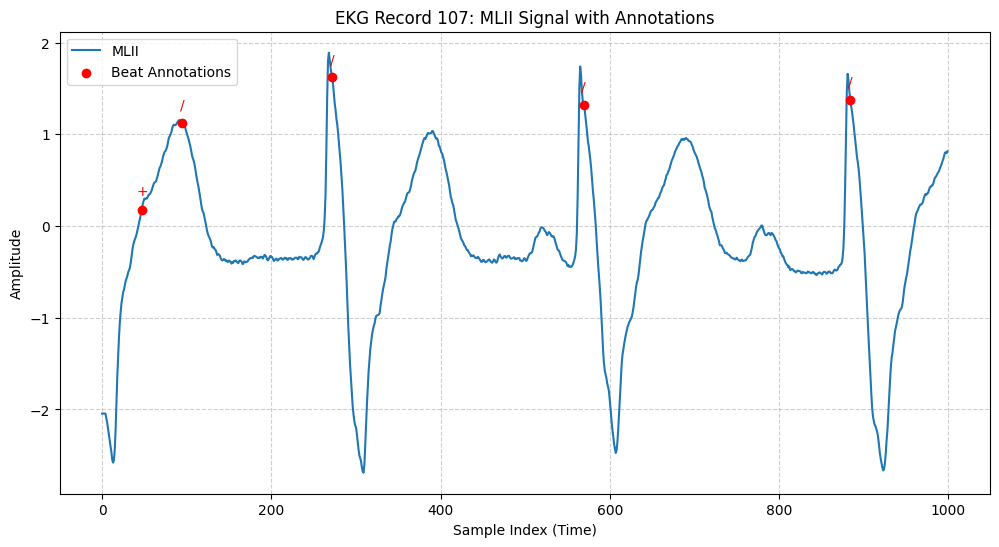

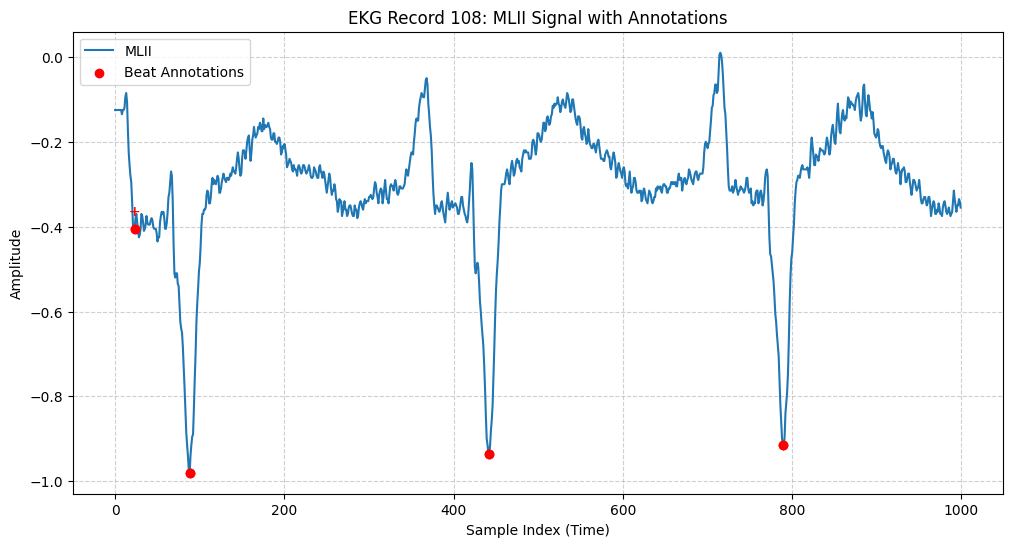

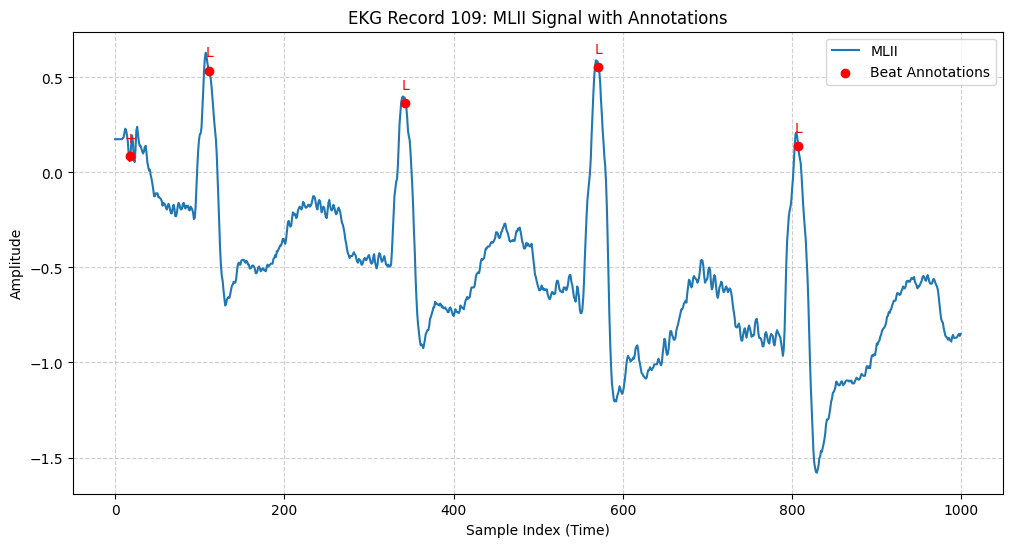

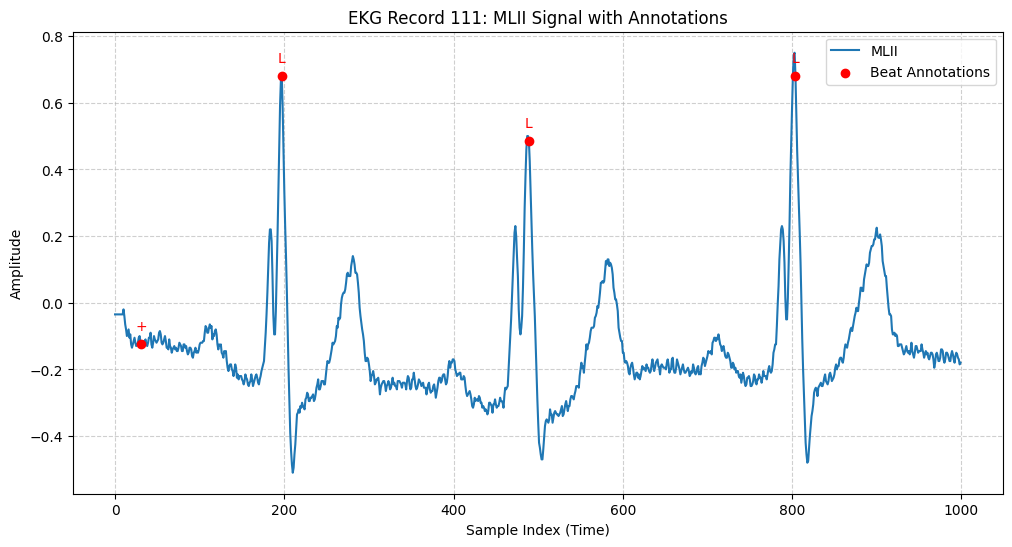

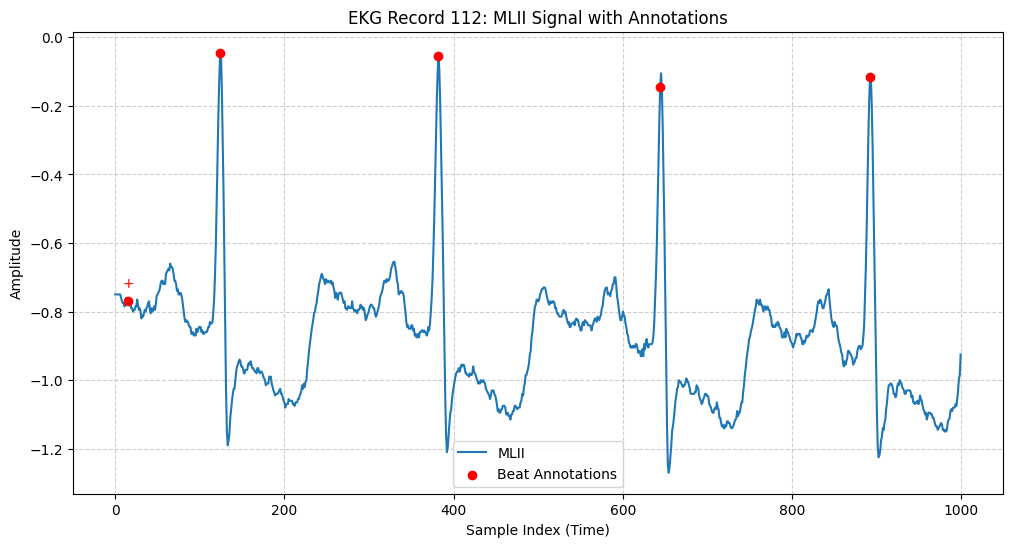

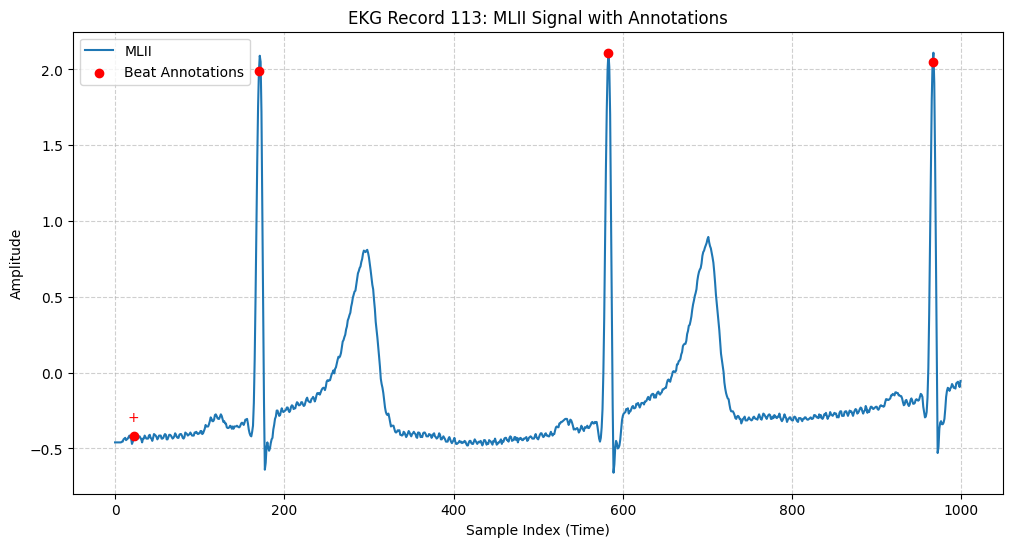

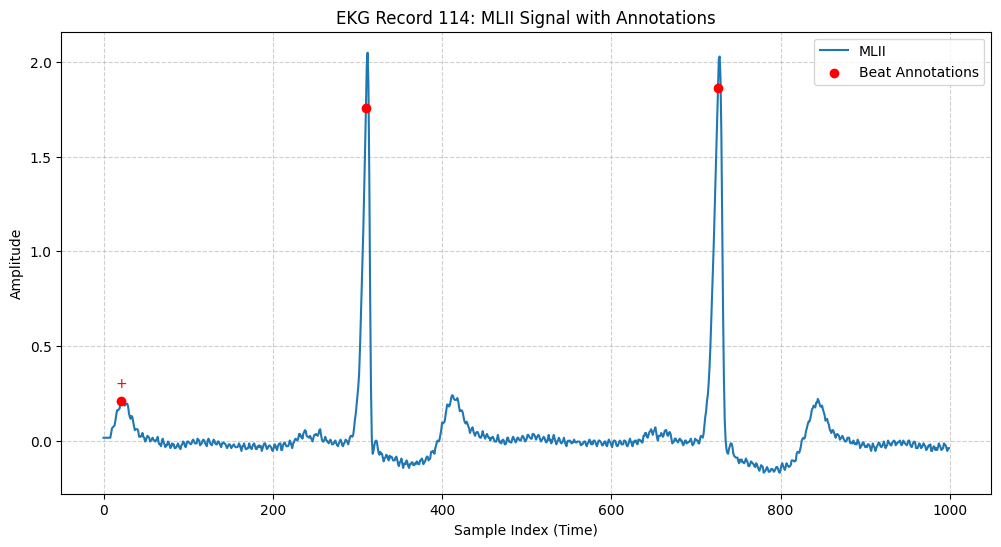

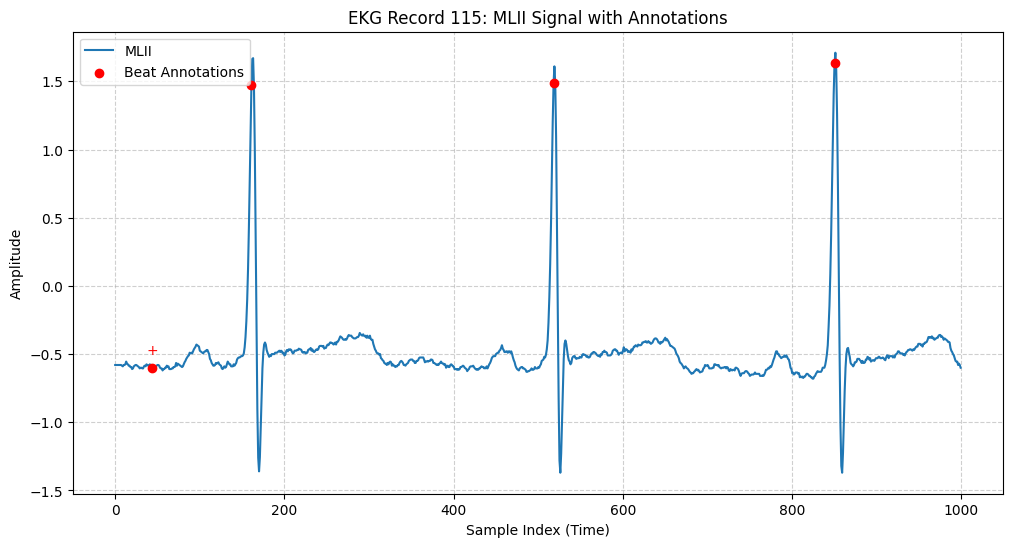

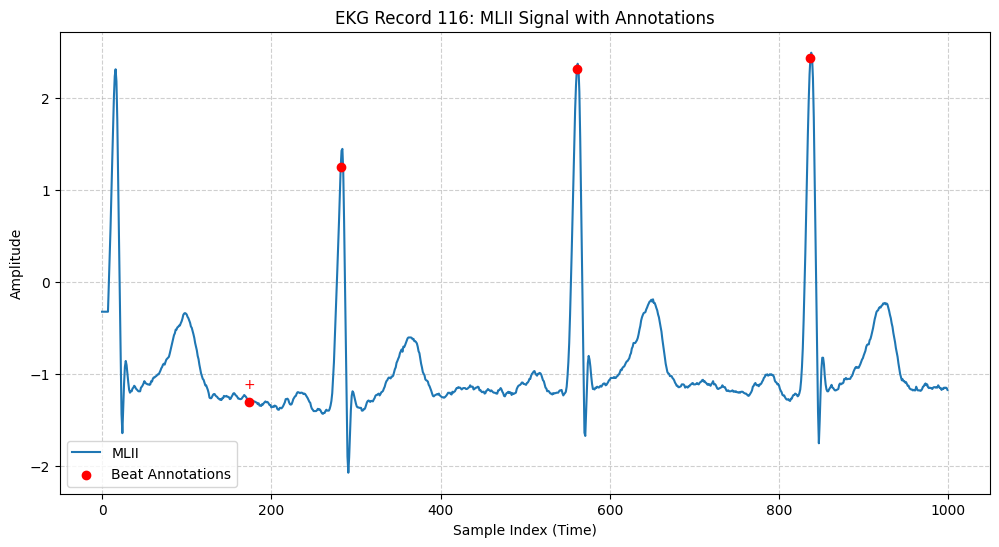

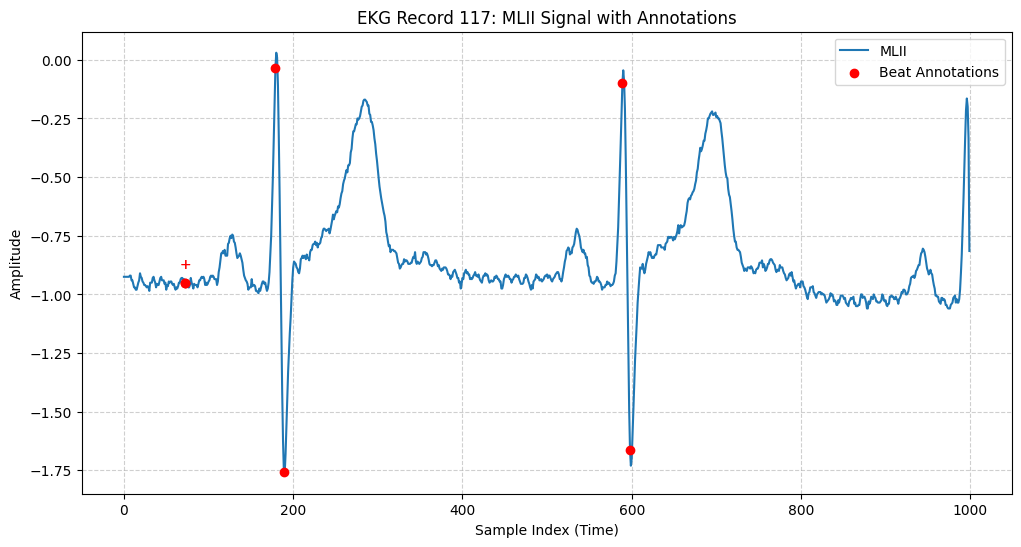

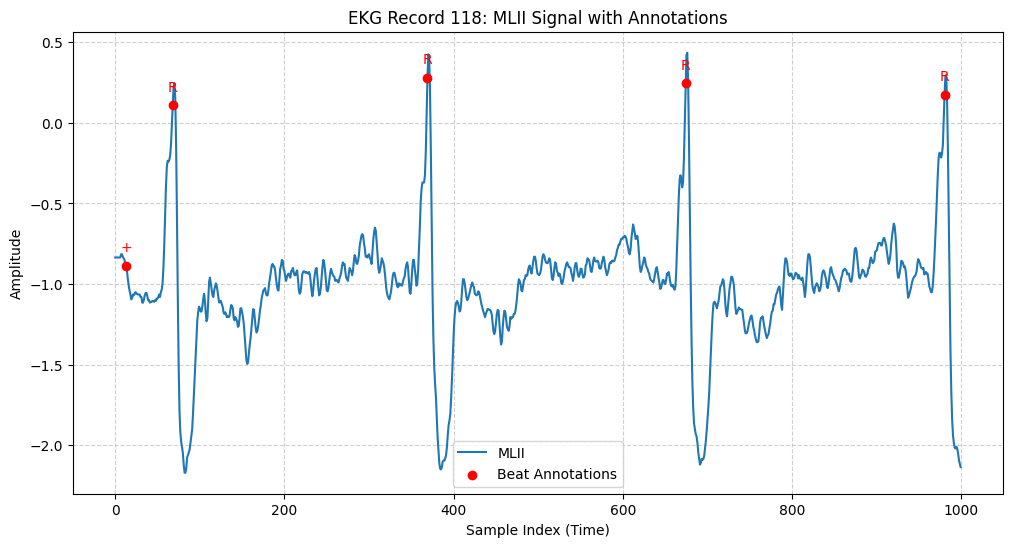

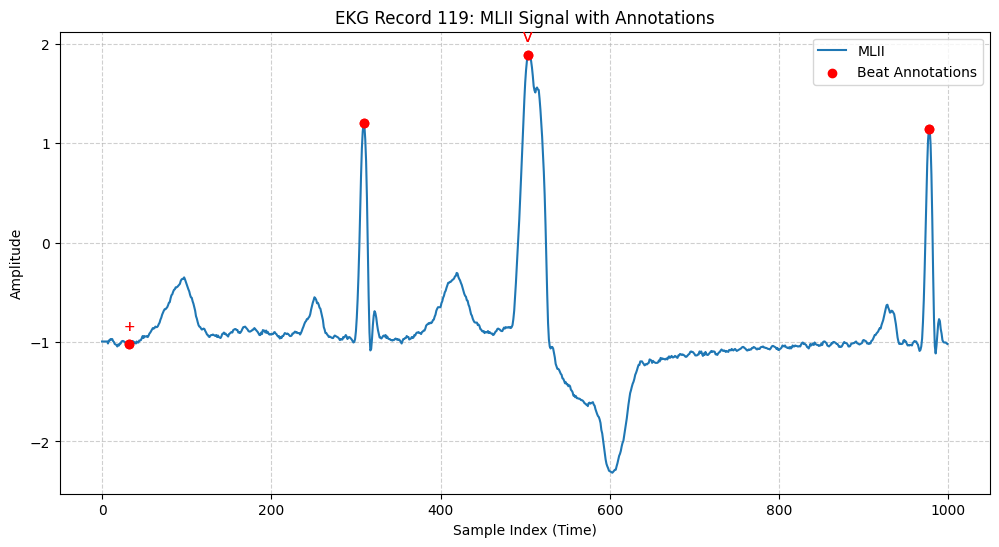

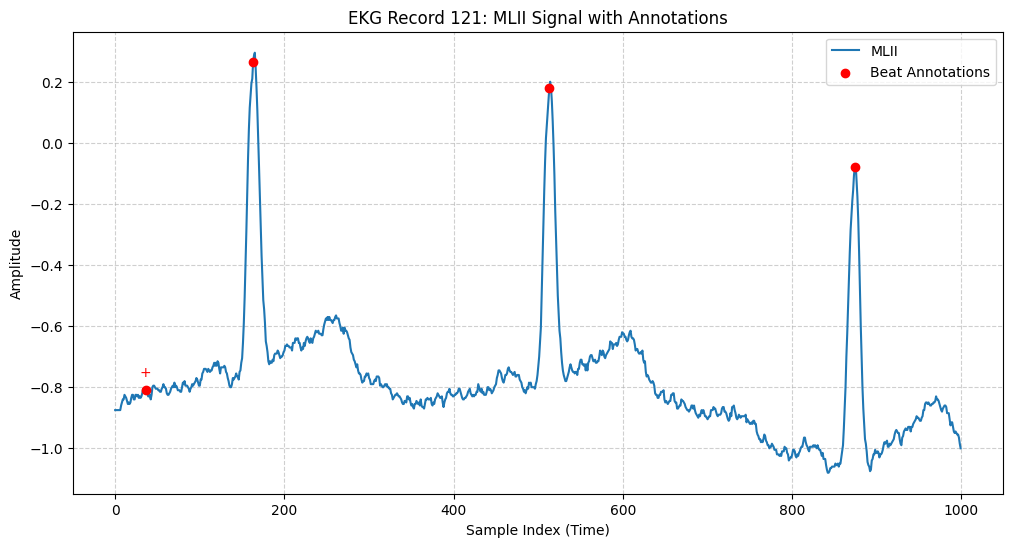

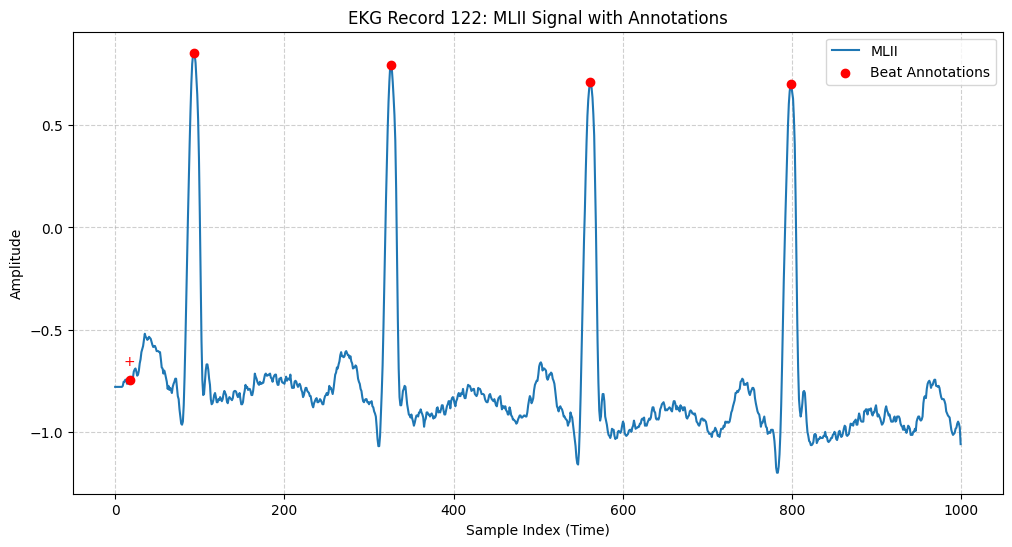

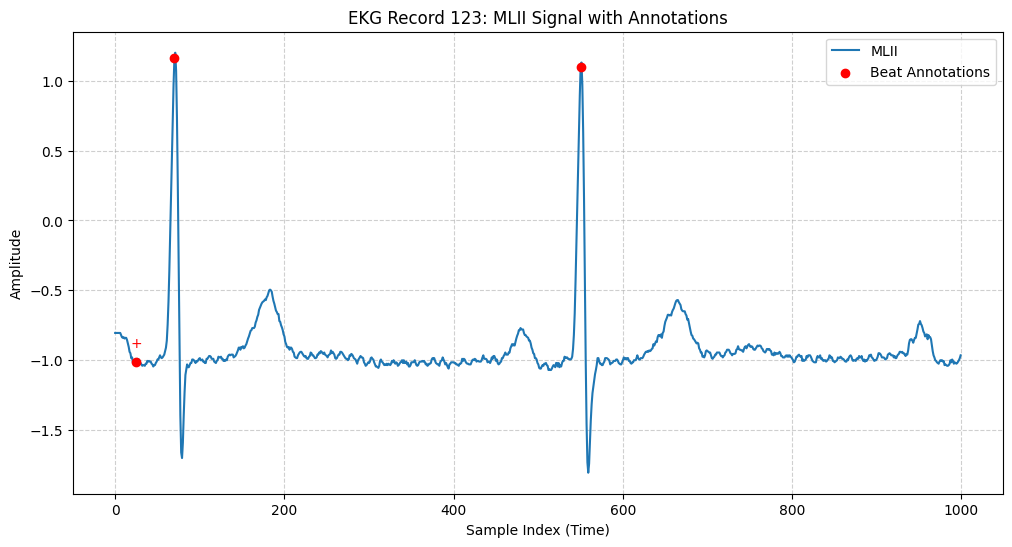

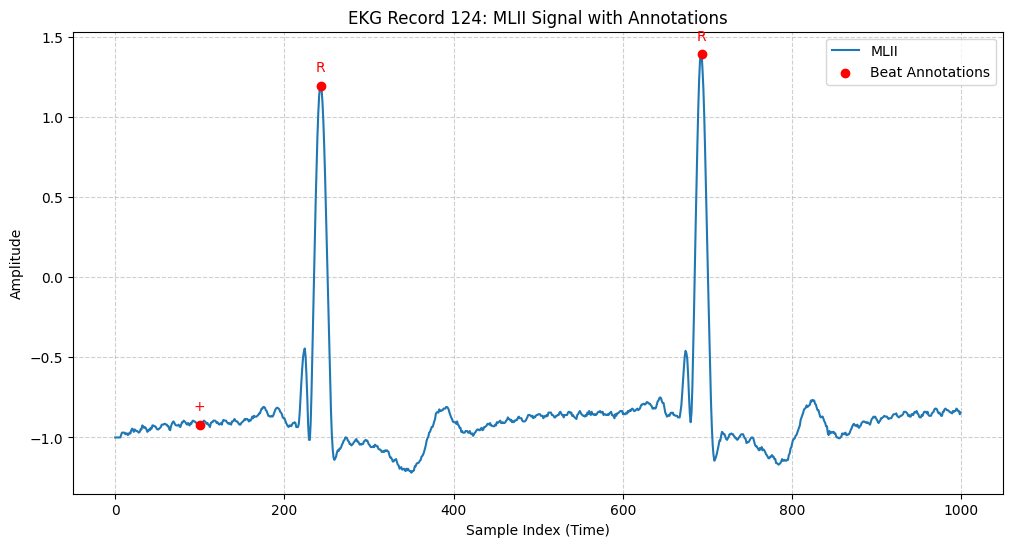

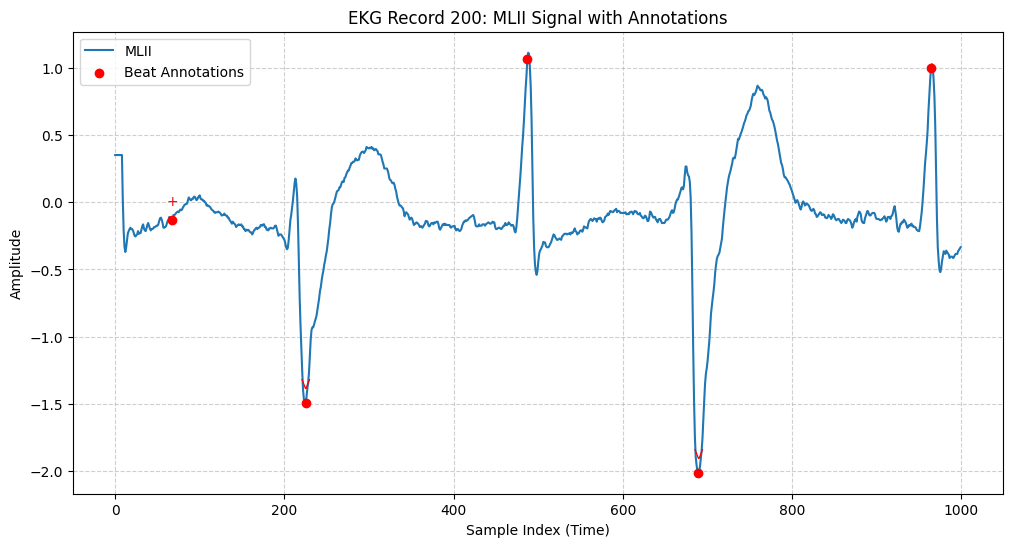

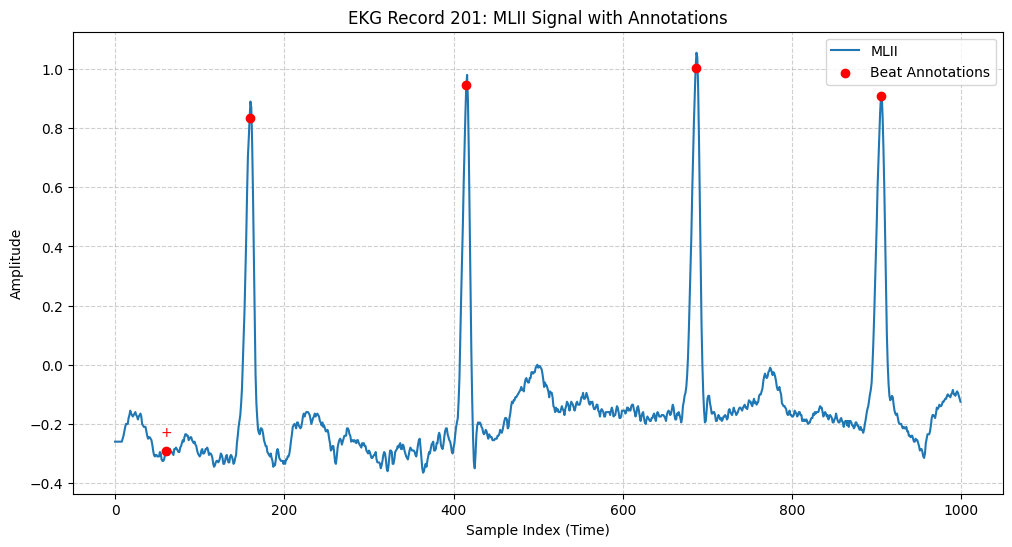

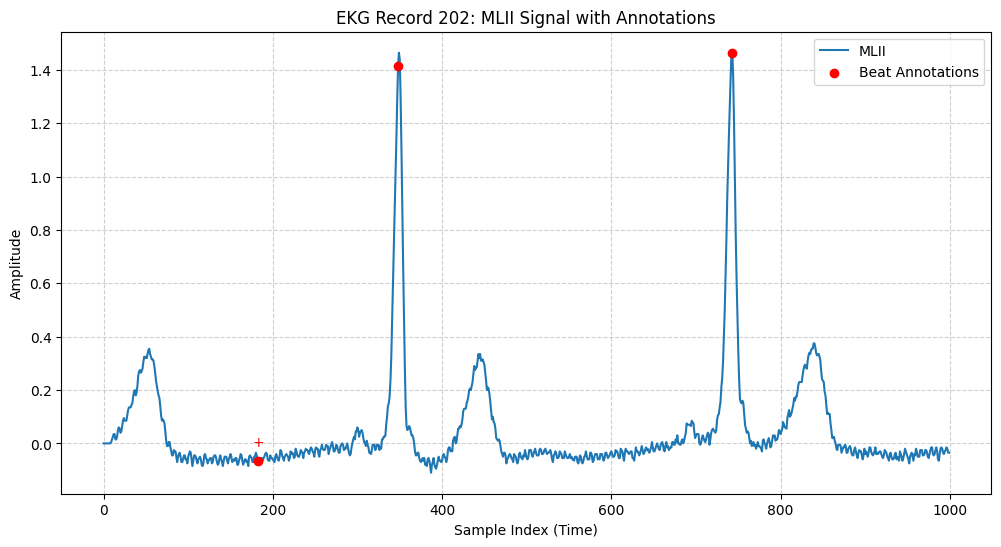

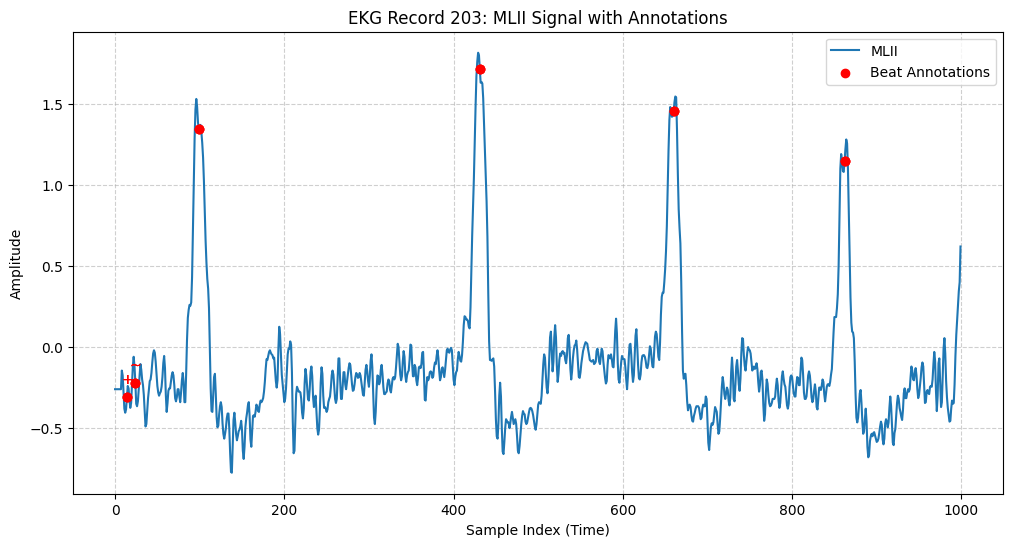

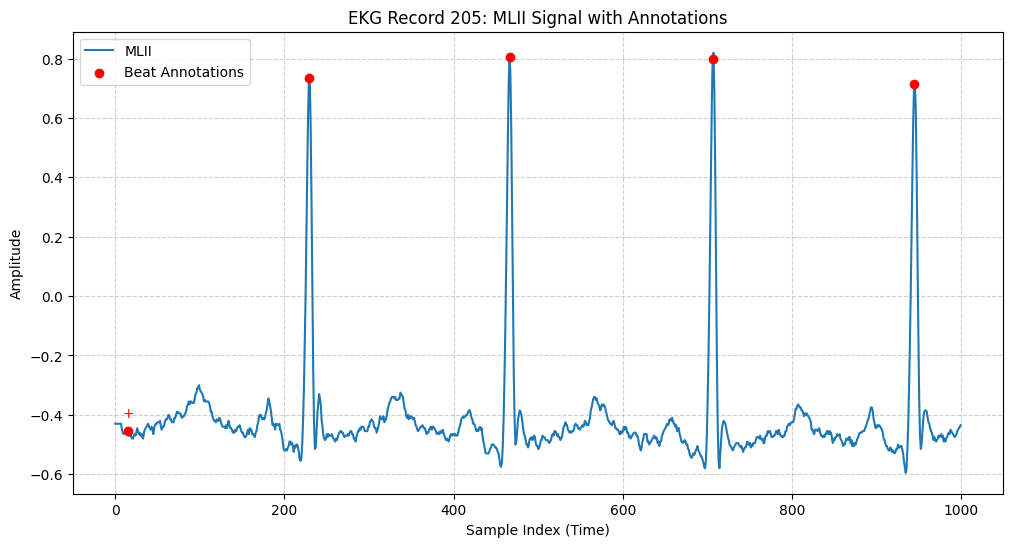

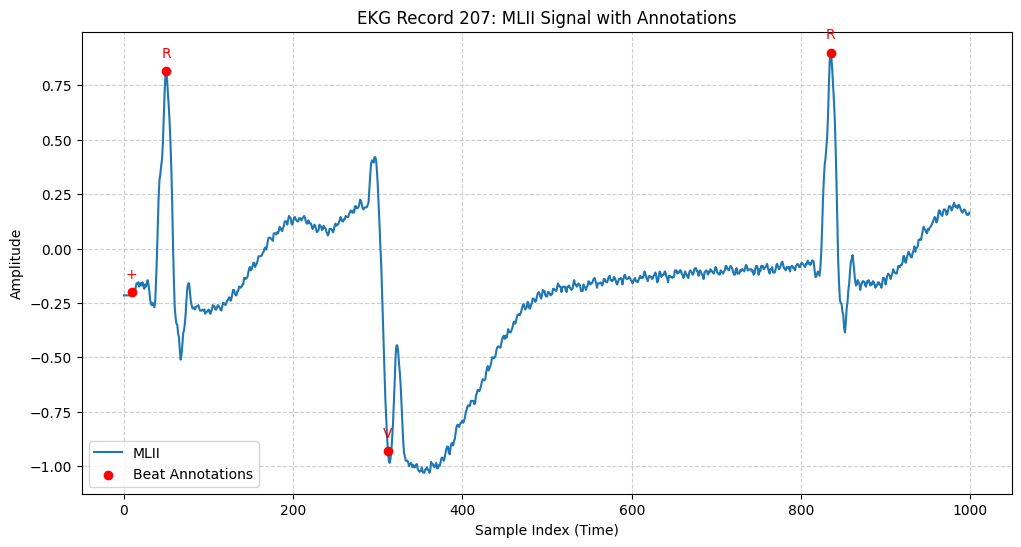

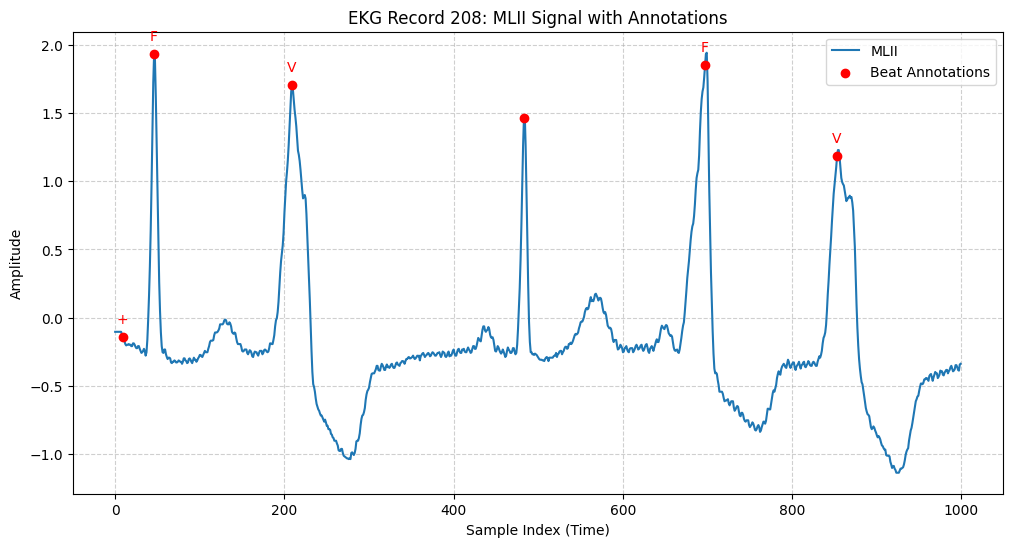

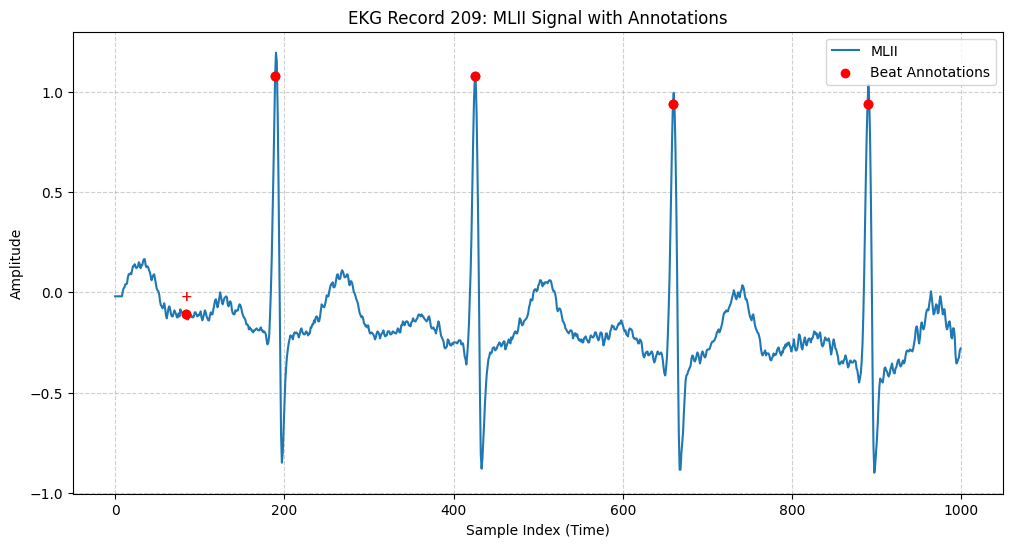

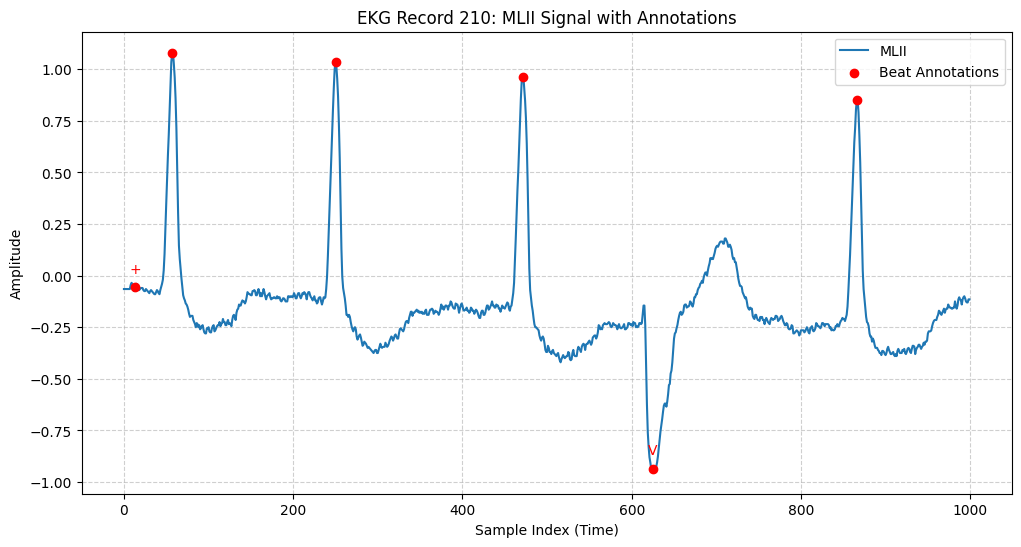

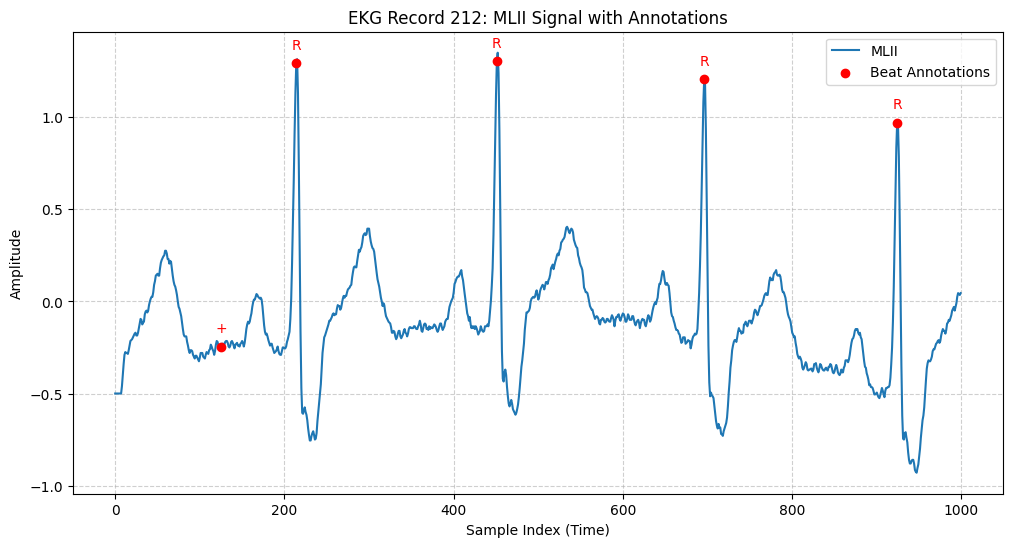

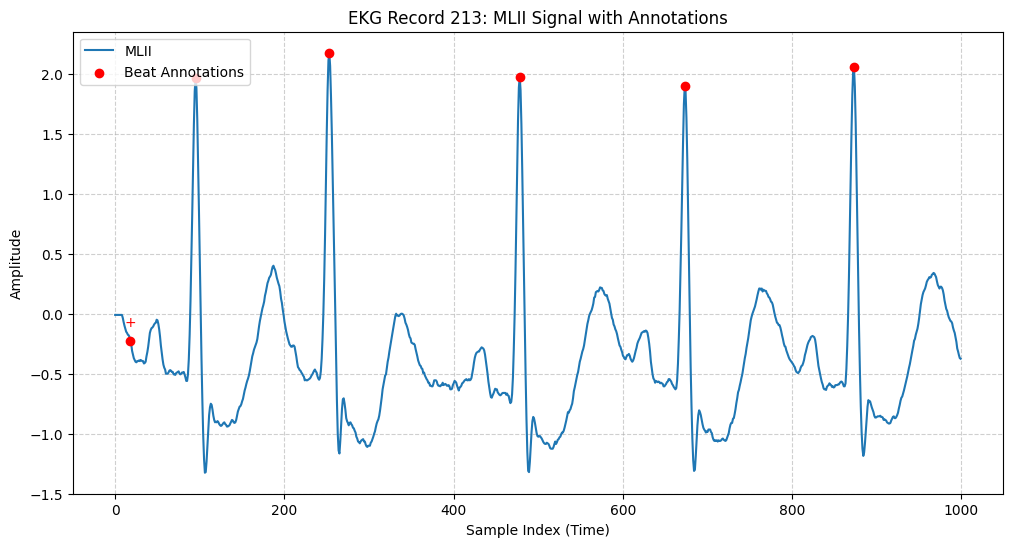

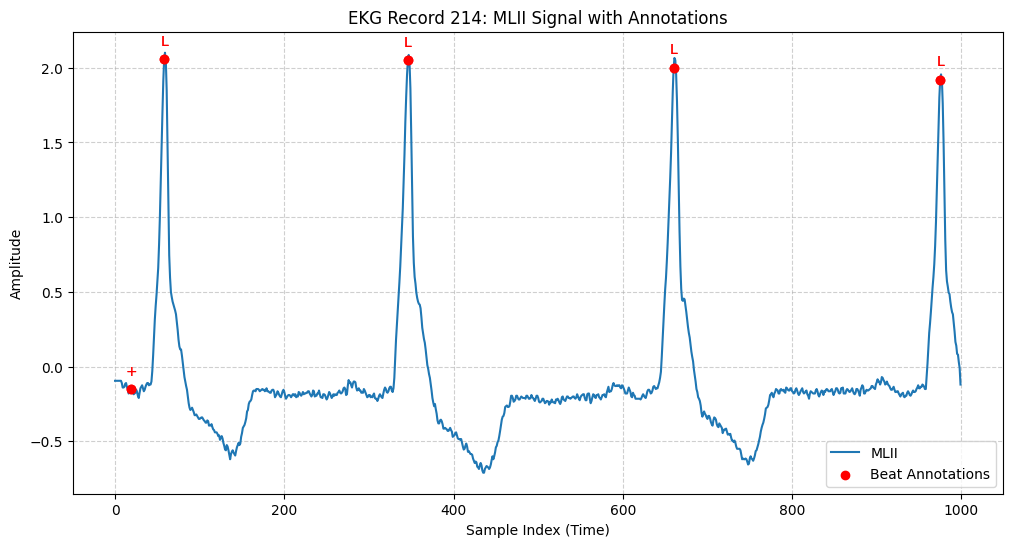

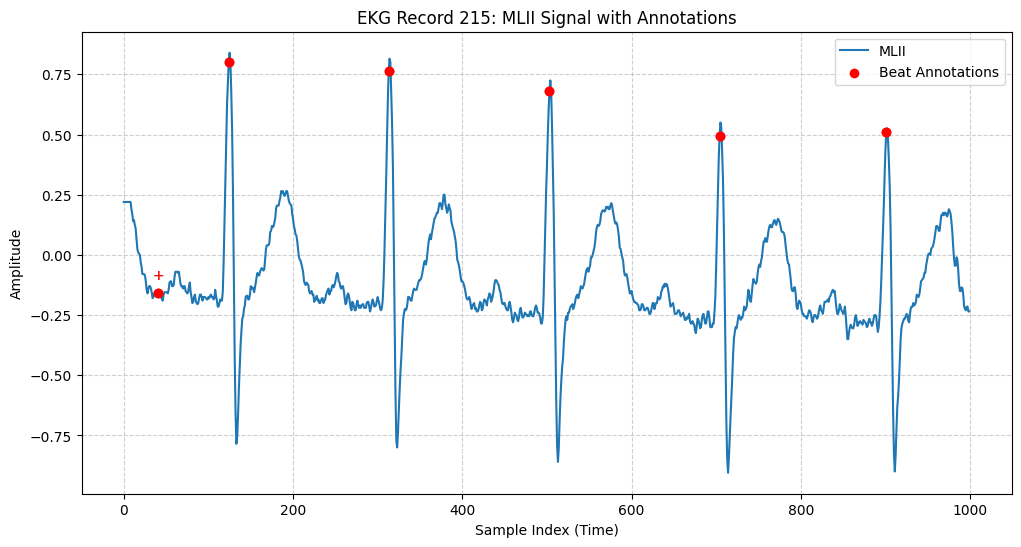

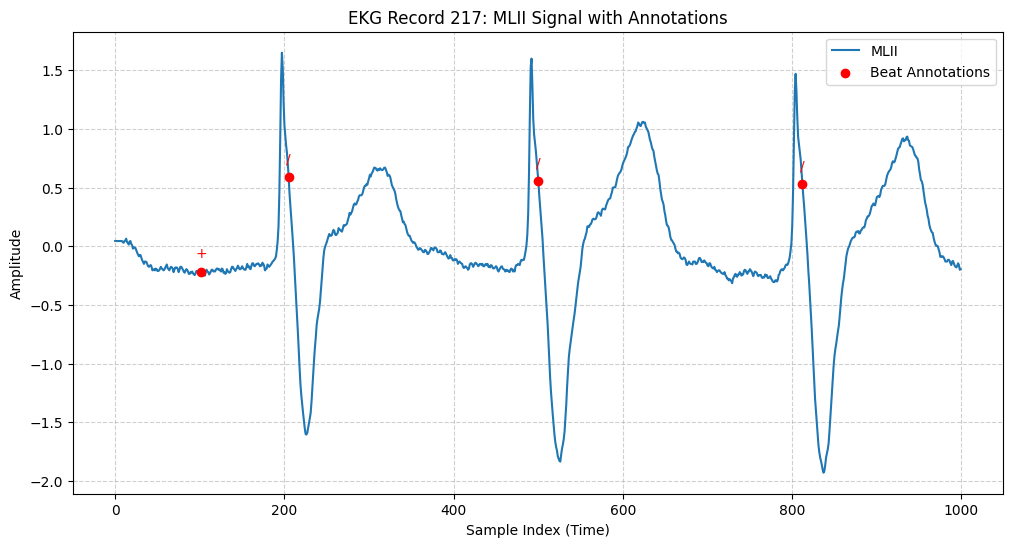

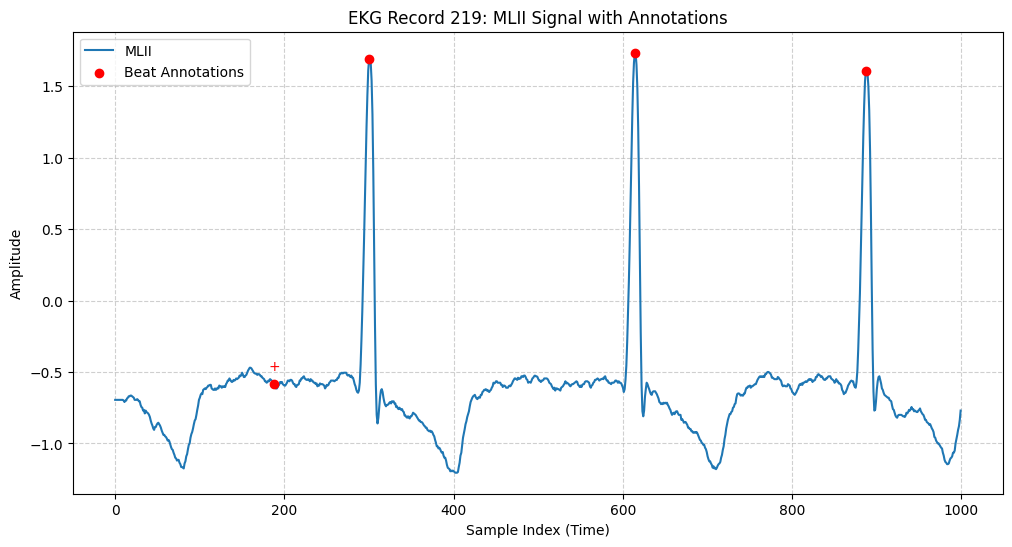

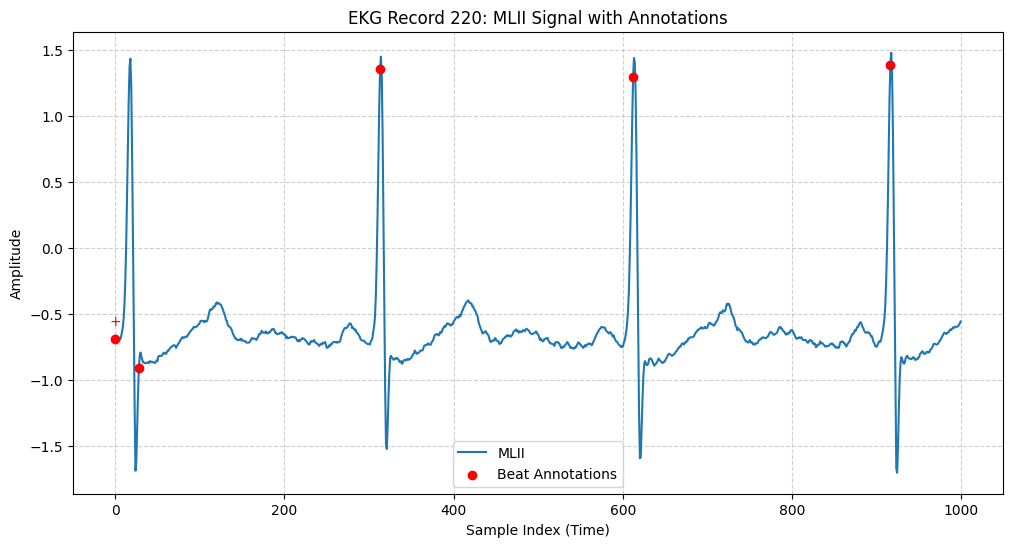

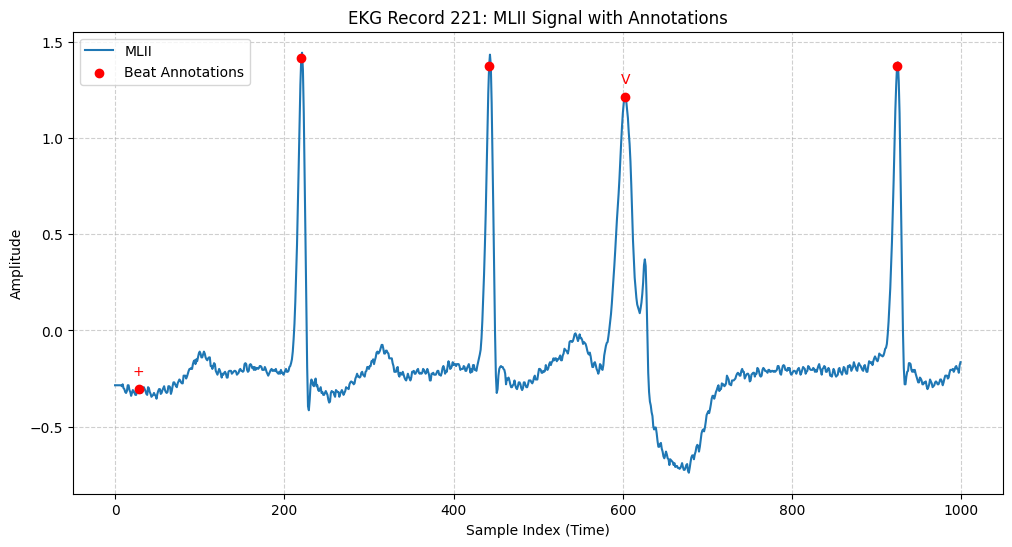

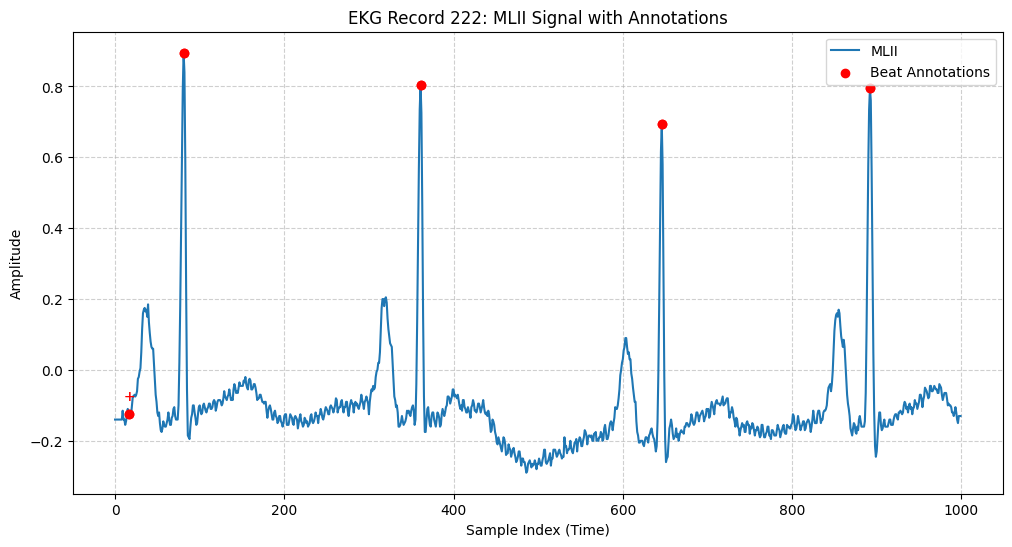

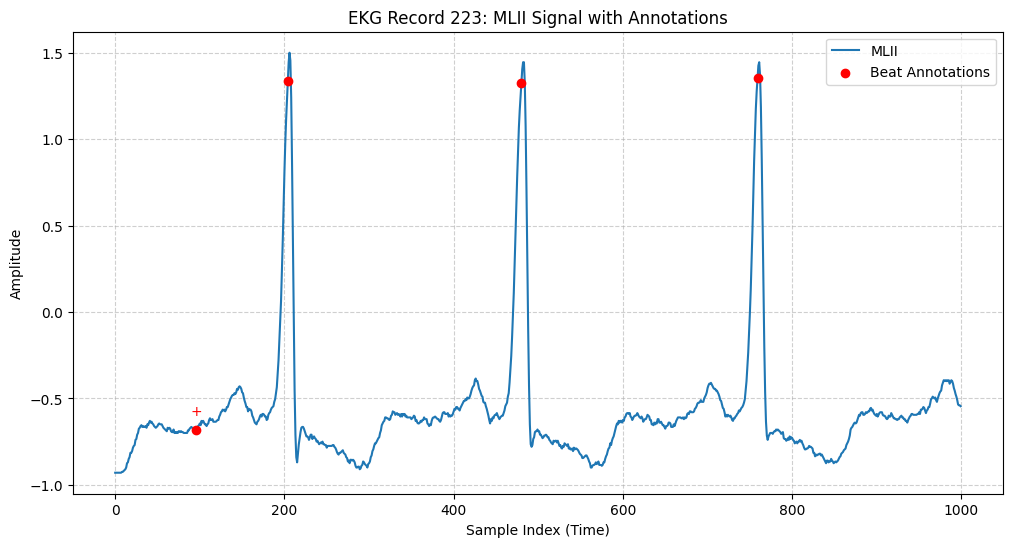

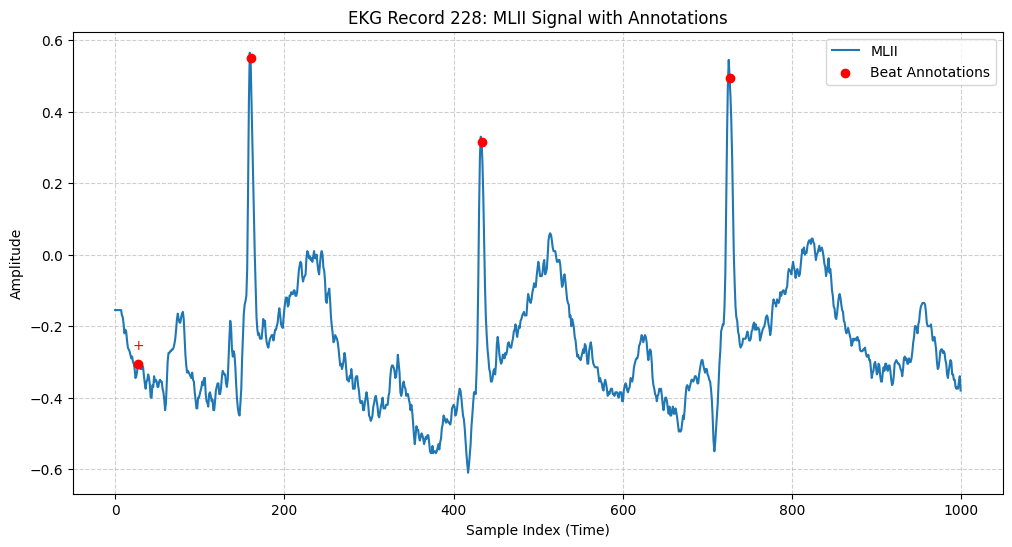

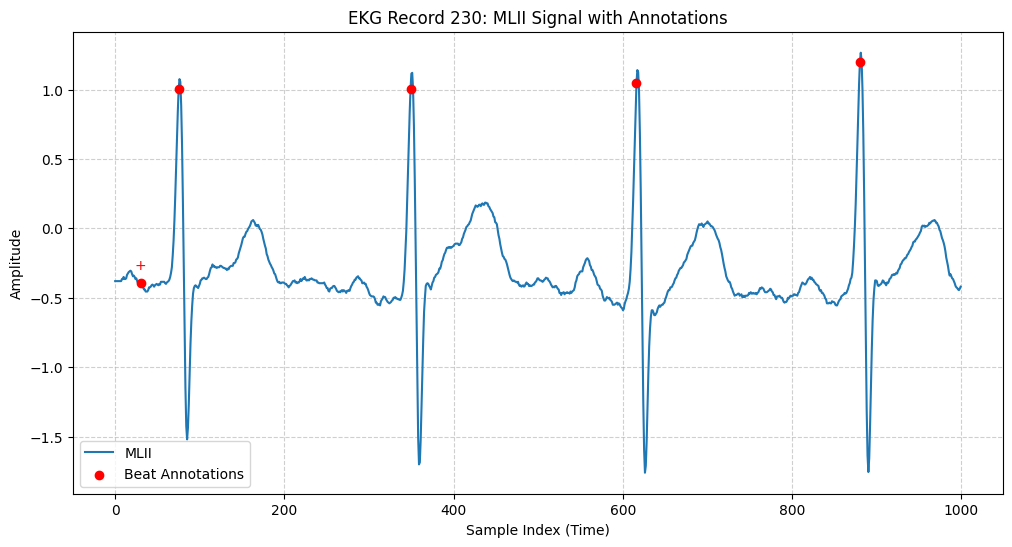

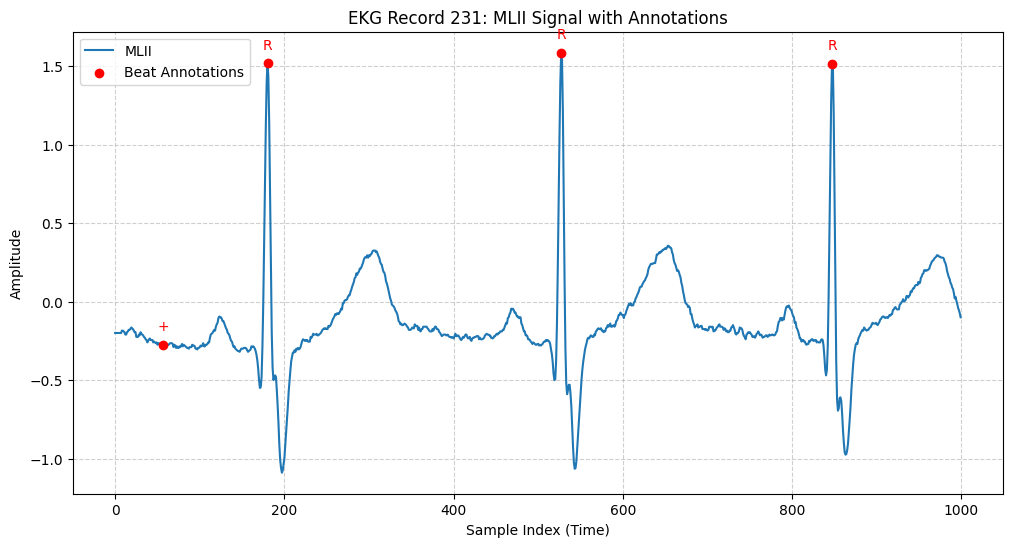

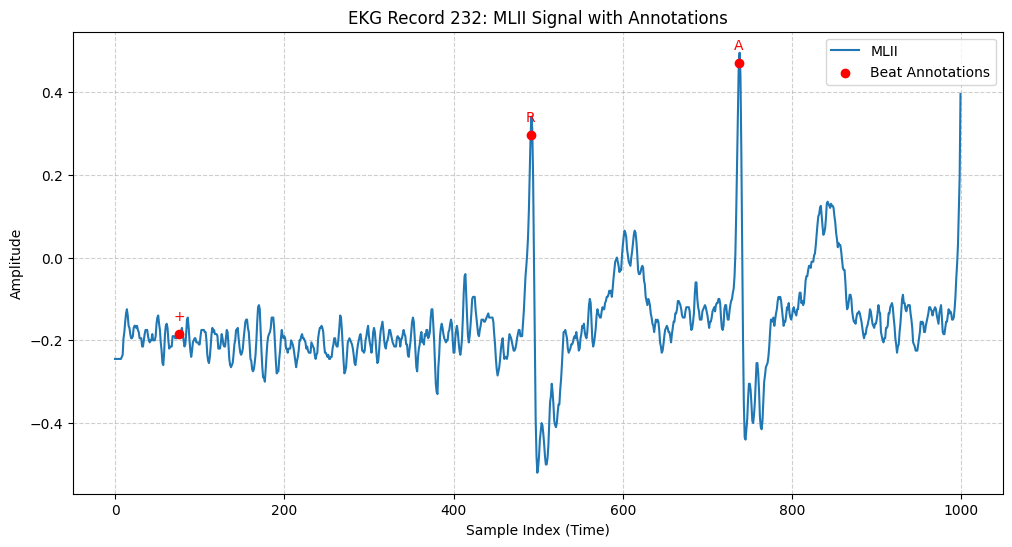

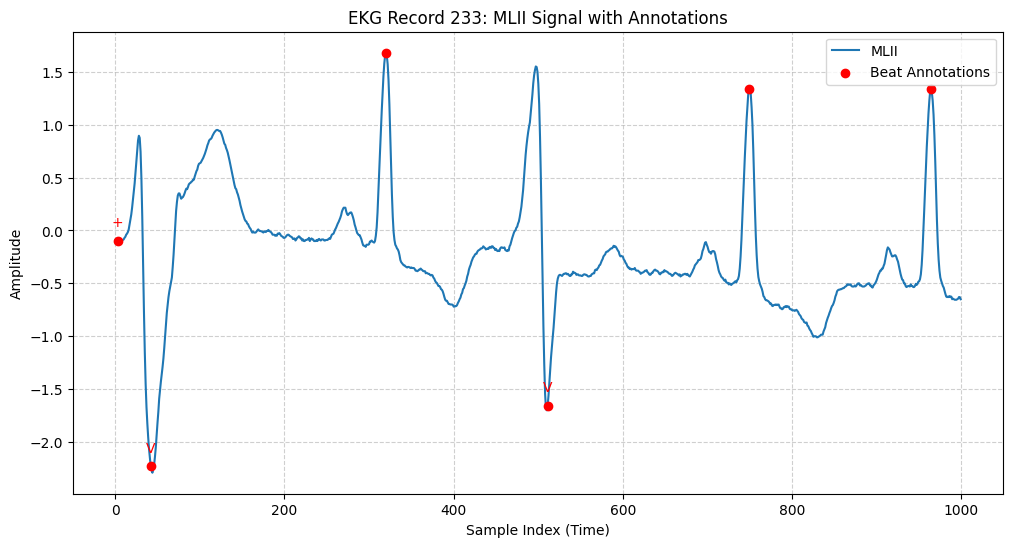

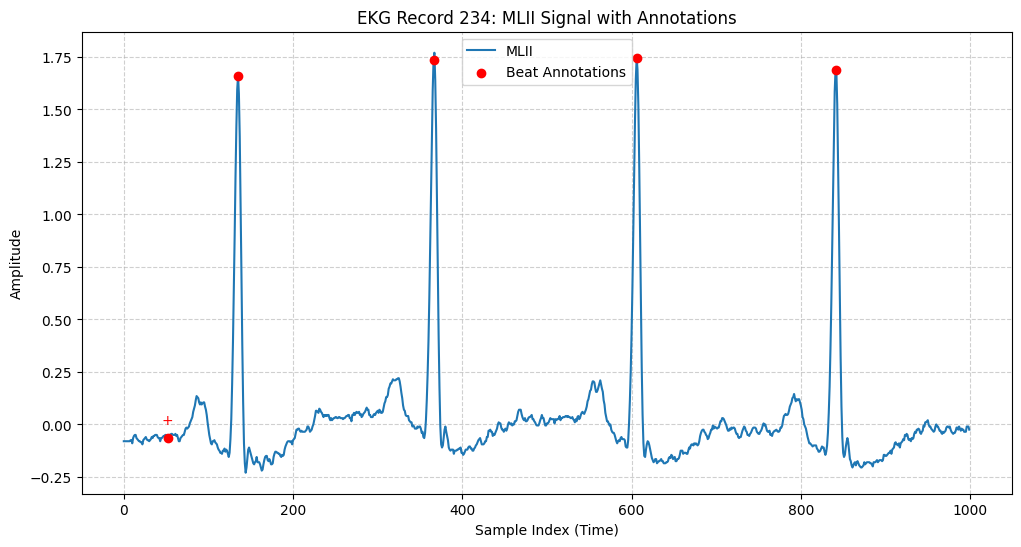

In [61]:
import matplotlib.pyplot as plt

SAMPLES_TO_PLOT = 1000
SIGNAL = "MLII"

for ekg_id, ekg_info in ekg_records.items():
    signal_data = ekg_info.signal
    if signal_data is None:
        print(f"Skipping record {ekg_id}: signal_data is None. File may be missing or failed to load.")
        continue  # Move to the next record
    signal_segment = signal_data[SIGNAL].iloc[:SAMPLES_TO_PLOT]

    annotations = ekg_info.annotations
    filtered_ann = annotations[annotations["index"] < SAMPLES_TO_PLOT].copy()
    ann_indices = filtered_ann["index"].astype(int).values
    ann_amplitudes = signal_segment.iloc[ann_indices].values

    plt.figure(figsize=(12, 6))
    plt.plot(signal_segment.index, signal_segment.values, label=SIGNAL)
    plt.scatter(ann_indices, ann_amplitudes, color="red", zorder=5, label="Beat Annotations")

    for x, y, symbol in zip(ann_indices, ann_amplitudes, filtered_ann["annotation_symbol"].values):
        if symbol not in ["N", "·"]:
            plt.annotate(symbol, (x, y), textcoords="offset points", xytext=(0, 10), ha="center", color="red",)

    plt.title(f"EKG Record {ekg_id}: {SIGNAL} Signal with Annotations")
    plt.xlabel("Sample Index (Time)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

### Resampling & Normalization

- Resampling: standardize signal sampling rate by either up or downsampling to a target value (e.g 1000)
- Scaling: fit values of signal onto a specified range (eg. (-1, 1))

In [62]:
import numpy as np
import pandas as pd
from scipy.signal import resample

SAMPLING_RATE = 1000
SIGNAL = "MLII"
standardized_signals = []
standardized_annotations = []

for ekg_id, ekg_info in ekg_records.items():
    original_signal = ekg_info.signal[SIGNAL].values
    
    resampled_signal = resample(original_signal, SAMPLING_RATE)
    resampling_ratio = len(resampled_signal) / len(original_signal)
    
    
    original_indices = ekg_info.annotations['index'].values 
    converted_indices = np.round(original_indices * resampling_ratio).astype(int)
    beat_types = ekg_info.annotations['annotation_symbol'].values
    
    standardized_signals.append(resampled_signal)
    
    annotation_map = dict(zip(converted_indices, beat_types))
    
    standardized_annotations.append(annotation_map)


In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

normalized_signals = []
for signal in standardized_signals:
    signal = signal.reshape(-1, 1)
    normalized_signal = scaler.fit_transform(signal).flatten()
    normalized_signals.append(normalized_signal)


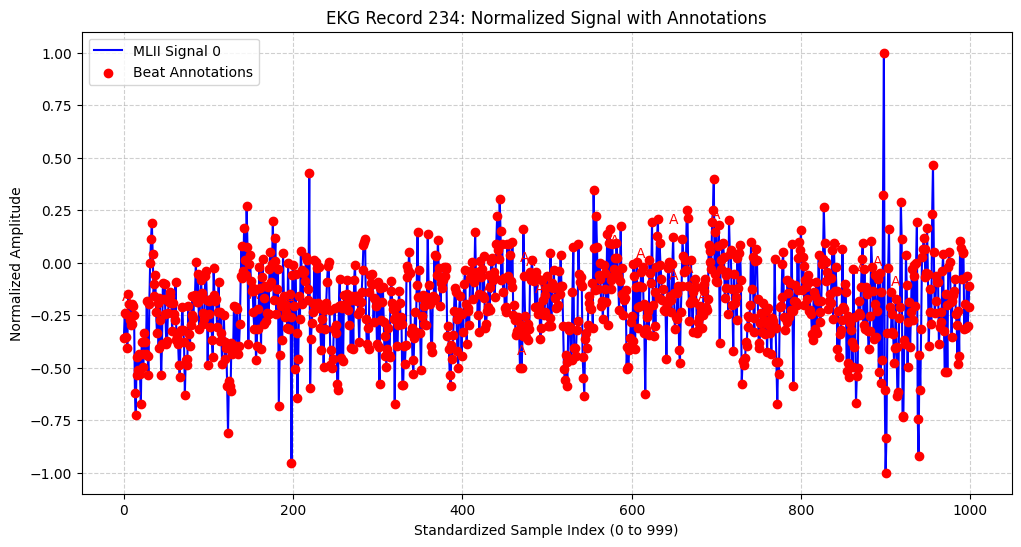

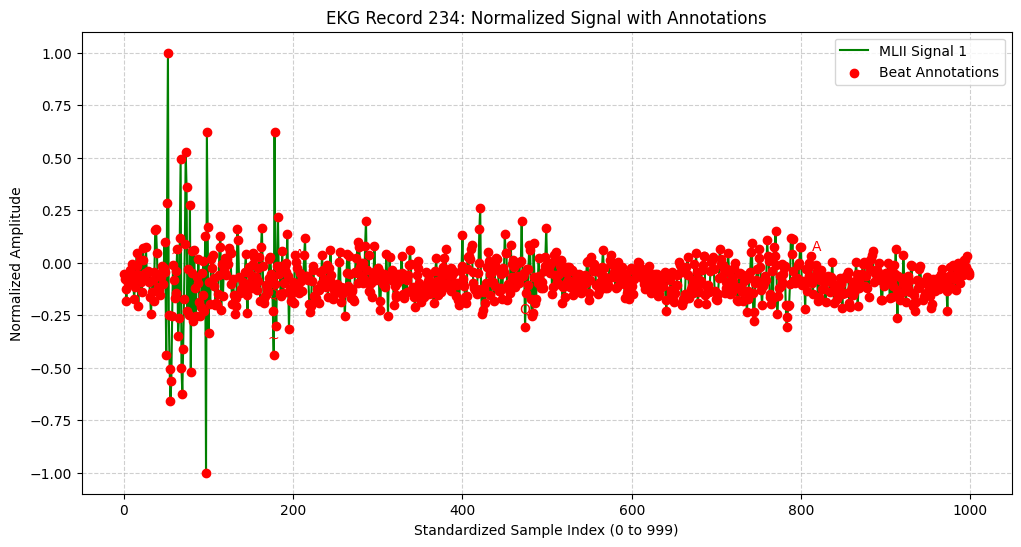

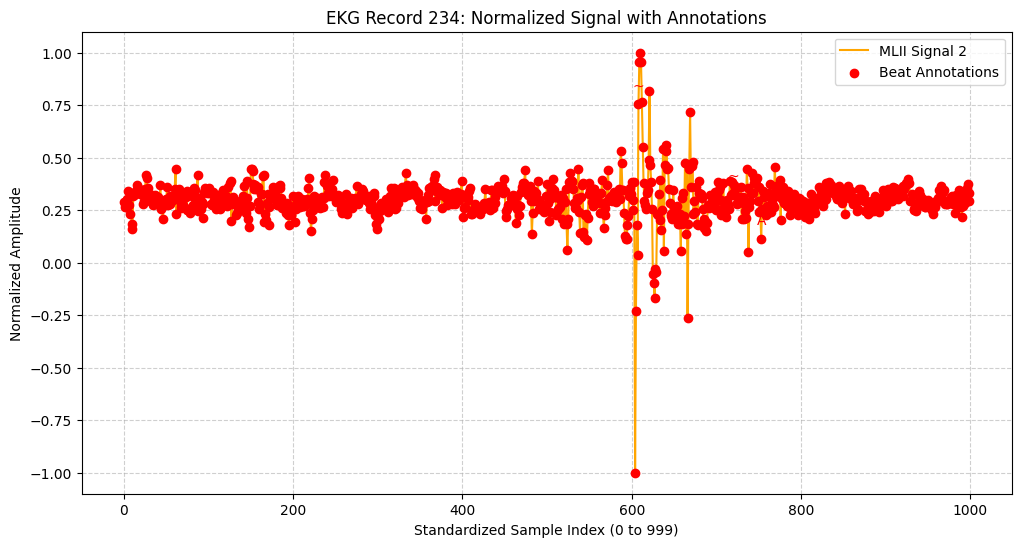

In [64]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['blue', 'green', 'orange'] 

for i, signal in enumerate(normalized_signals[:3]):
    annotation_map = standardized_annotations[i]
    current_color = colors[i % len(colors)]
    
    ann_indices = np.array(list(annotation_map.keys()))
    ann_symbols = np.array(list(annotation_map.values()))
    
    valid_indices = ann_indices[ann_indices < len(signal)]
    valid_symbols = ann_symbols[ann_indices < len(signal)]
    
    ann_amplitudes = signal[valid_indices]
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(signal, label=f"{SIGNAL} Signal {i}", color=current_color)
    
    plt.scatter(valid_indices, ann_amplitudes, color='red', zorder=5, label='Beat Annotations')

    for x, y, symbol in zip(valid_indices, ann_amplitudes, valid_symbols):
        if symbol not in ['N', '·']: 
            plt.annotate(symbol, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    plt.title(f"EKG Record {ekg_id}: Normalized Signal with Annotations")
    plt.xlabel(f"Standardized Sample Index (0 to {SAMPLING_RATE-1})")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

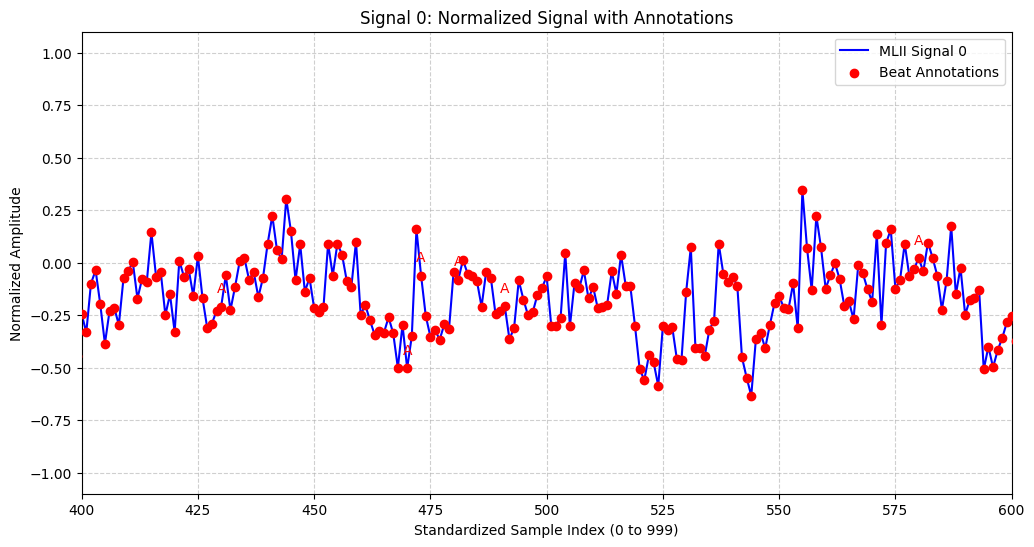

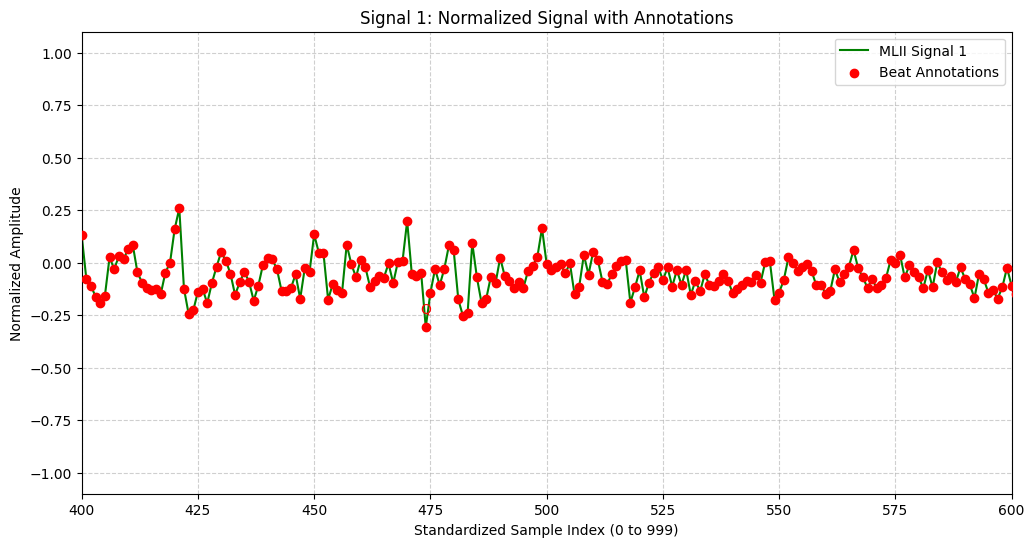

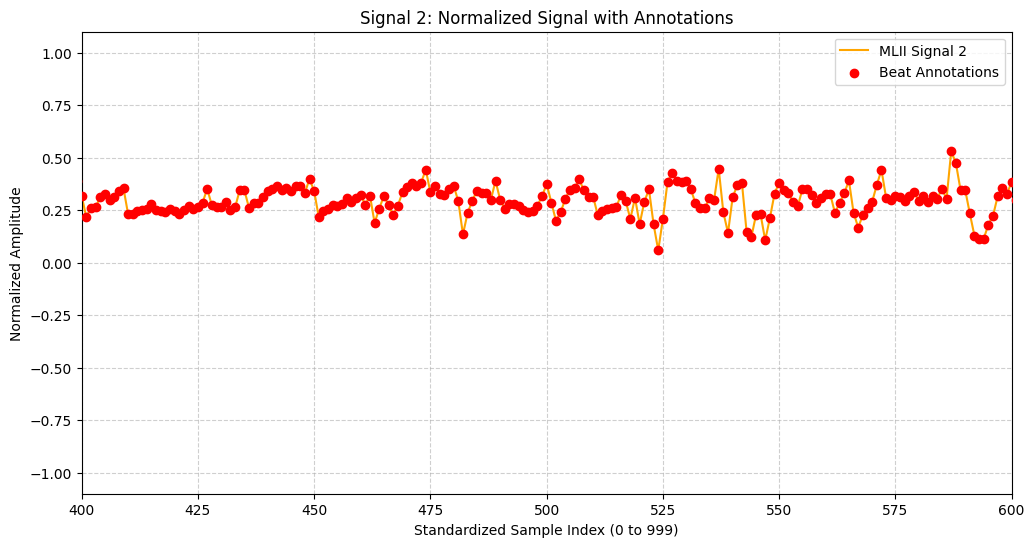

In [65]:
import matplotlib.pyplot as plt
import numpy as np

START, END = 400, 600

colors = ['blue', 'green', 'orange'] 

for i, signal in enumerate(normalized_signals[:3]):
    annotation_map = standardized_annotations[i]
    current_color = colors[i % len(colors)]
    
    ann_indices = np.array(list(annotation_map.keys()))
    ann_symbols = np.array(list(annotation_map.values()))
    
    valid_indices = ann_indices[ann_indices < len(signal)]
    valid_symbols = ann_symbols[ann_indices < len(signal)]
    
    ann_amplitudes = signal[valid_indices]
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(signal, label=f"{SIGNAL} Signal {i}", color=current_color)
    
    plt.scatter(valid_indices, ann_amplitudes, color='red', zorder=5, label='Beat Annotations')

    for x, y, symbol in zip(valid_indices, ann_amplitudes, valid_symbols):
        if symbol not in ['N', '·']: 
            plt.annotate(symbol, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    plt.title(f"Signal {i}: Normalized Signal with Annotations")
    plt.xlabel(f"Standardized Sample Index (0 to {SAMPLING_RATE-1})")
    plt.ylabel("Normalized Amplitude")
    plt.xlim(START, END)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

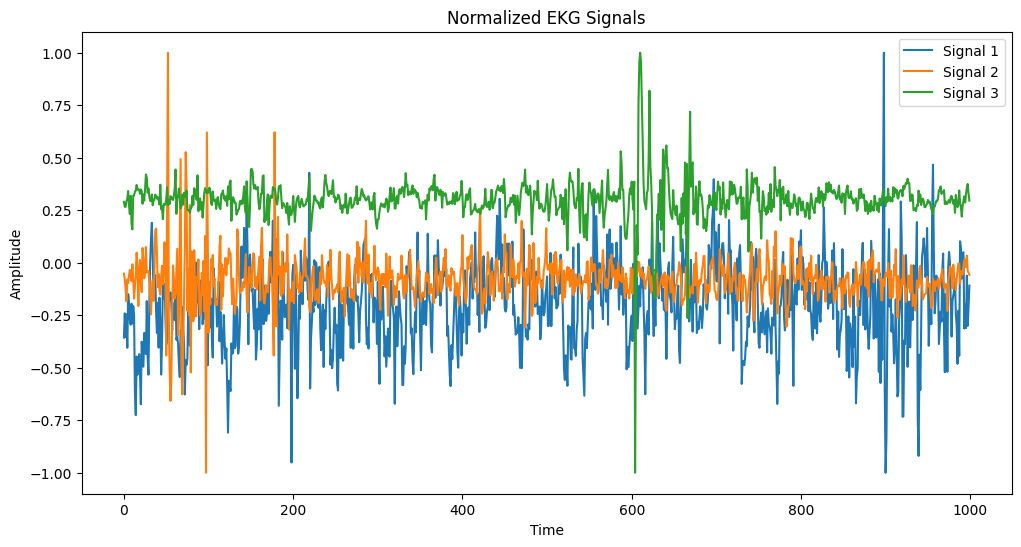

In [66]:
# Visualize first 3 signals after stnandardization and normalization

plt.figure(figsize=(12, 6))
for i, signal in enumerate(normalized_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Normalized EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


## Noise Reduction and Filtering

### 1. Fundamental Filter Actions

| Term | Details |
| :--- | :--- |
| **Filtering** | Isolates desired frequencies and rejects unwanted components. |
| **Passband** | **Passes** (or transmits) desired signal frequencies. |
| **Stopband** | **Attenuates** (or reduces the amplitude of) unwanted frequencies/noise. |
| **Smoothing** | A type of low-pass filtering, specifically used to mitigate **high-frequency noise** and rapid fluctuations. |

---

### 2. Types of Filters

| Filter Type | Function | Defined By |
| :--- | :--- | :--- |
| **Bandpass** | Passes frequencies **within** a defined range. | Lower Cutoff ($f_{low}$) and Upper Cutoff ($f_{high}$) |
| **Low-Pass** | Passes frequencies **below** a defined limit. | Upper Cutoff ($f_{high}$) |
| **High-Pass** | Passes frequencies **above** a defined limit. | Lower Cutoff ($f_{low}$) |

---

### 3. Filter Types
#### Butterworth Filter

| Parameter | Definition | Significance |
| :--- | :--- | :--- |
| **Order ($N$)** | The mathematical complexity of the filter (number of poles/zeros). | Determines the **steepness of the roll-off**. A higher order creates a narrower **Transition Band** (better selectivity). <br/><br/> <img src="https://i.sstatic.net/7oRMG.png" width="50%" />|
| **Cutoff Frequency ($f_c$)** | The frequency at which the filter's power output is reduced by $3\text{ dB}$ (half power). | Defines the boundary between the Passband and the Stopband. |
| **Transition Band** | The frequency range between the Passband and the Stopband where attenuation gradually increases. |


##### Nyquist Theorem

* **Sampling Frequency ($f_s$):** The rate at which an analog signal is converted to digital (samples per second).
* **Nyquist Frequency ($f_{\text{Nyquist}}$):** The maximum frequency that can be accurately represented by a given sampling rate.
    $$f_{\text{Nyquist}} = \frac{f_s}{2}$$
* **Aliasing:** A distortion where the digital wave has different frequency than original, analog wave due to a low sampling rate.

---
### 4. Smoothing Methods

#### Moving Averagee
A **Moving Average** flattens the signal by calculating a mean, which **rounds off sharp features** (like the peak of the QRS complex).

#### Savitzky-Golay Filter
The **S-G filter** is a **low-pass filter** used to remove high-frequency noise while preserving the shape and features of the signal.
* Uses the polynomial to **preserve the local features** (like sharp peaks and steep slopes) while still effectively attenuating the high-frequency noise. It maintains the signal's morphology better than movingaverage

| Parameter | Description |
| :--- | :--- |
| **`window_length` (e.g., 11)** | The number of data points used to calculate the new smoothed value at the center point. Must be an **odd integer**. |
| **`polyorder` (e.g., 3)** | The degree of the polynomial used for fitting. Must be **less than** the `window_length`. |

1.  **Local Polynomial Fit:** For every point in the signal, the S-G filter takes the defined `window_length` of surrounding points.
2.  **Least Squares:** It performs a **least-squares polynomial fit** of degree `polyorder` to that small segment of data. 
3.  **Output:** The new smoothed value at the center of the window is the value of the calculated polynomial at that center point.


### 5. Denoising Methods
#### Wavelet Denoising
| Parameter | Description | Impact on Denoising |
| :--- | :--- | :--- |
| **Wavelet Type** | The specific function (e.g., Daubechies, Coiflet, Symlet) used to decompose the signal. | Determines how well the wavelet matches the signal's shape (morphology). |
| **Decomposition Level** | The number of times the signal is iteratively decomposed. | Determines the **frequency resolution** (how finely the signal is separated by scale). Higher levels are needed for lower-frequency noise. |
| **Thresholding Rule** | The method used to shrink or zero out the noisy coefficients (e.g., hard, soft, or sure). | Directly controls the **aggressiveness** of noise removal versus signal preservation. |
| **Threshold Value ($\lambda$)** | The actual cutoff value used in the thresholding step. | A **higher threshold** removes more noise but risks removing low-amplitude signal components. |

In [67]:
from scipy.signal import butter, filtfilt

SAMPLING_FREQ = 360

def bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, order=4):
    nyquist = 0.5 * SAMPLING_FREQ
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signals = [bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50) for signal in normalized_signals]


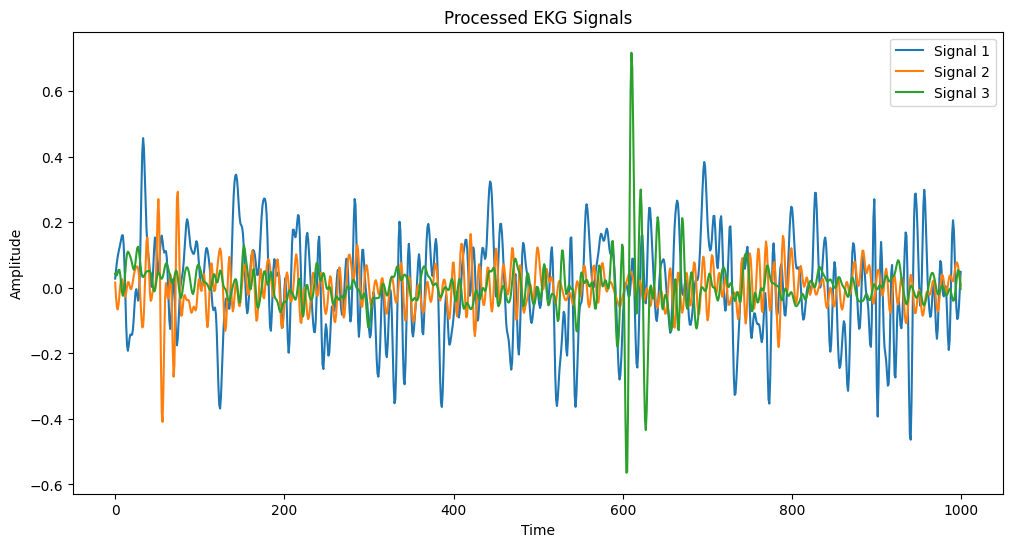

In [68]:
# Visualize first 3 signals after bandpass filter
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(filtered_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Processed EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [69]:
def bandpass_filter(signal, low_cutoff=0.5, high_cutoff=40, fs=360, order=4):
    nyquist = 0.5 * fs
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signals = [bandpass_filter(signal, low_cutoff=0.5, high_cutoff=40, fs=360) for signal in standardized_signals]


In [70]:
import numpy as np

def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

smoothed_signals = [moving_average(signal, window_size=5) for signal in filtered_signals]


In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_signals = [scaler.fit_transform(signal.reshape(-1, 1)).flatten()
                      for signal in smoothed_signals]


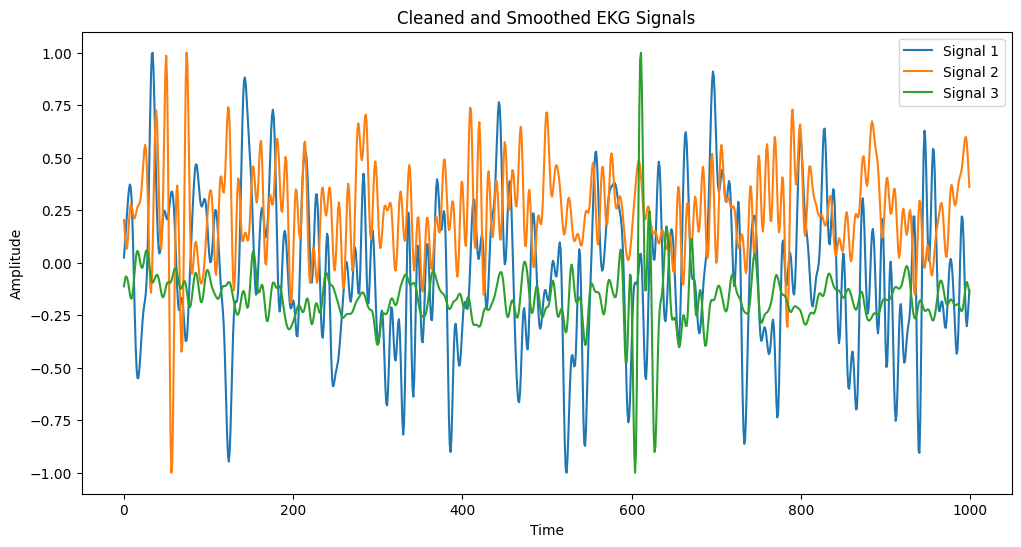

In [72]:
# Visualize first 3 signals after bandpass filter > bandpass filter > moving average

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(normalized_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Cleaned and Smoothed EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [73]:
def bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, fs=360, order=4):
    nyquist = 0.5 * fs
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signals = [bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, fs=360) for signal in standardized_signals]


In [74]:
from scipy.signal import savgol_filter

smoothed_signals = [savgol_filter(signal, window_length=11, polyorder=3) for signal in filtered_signals]


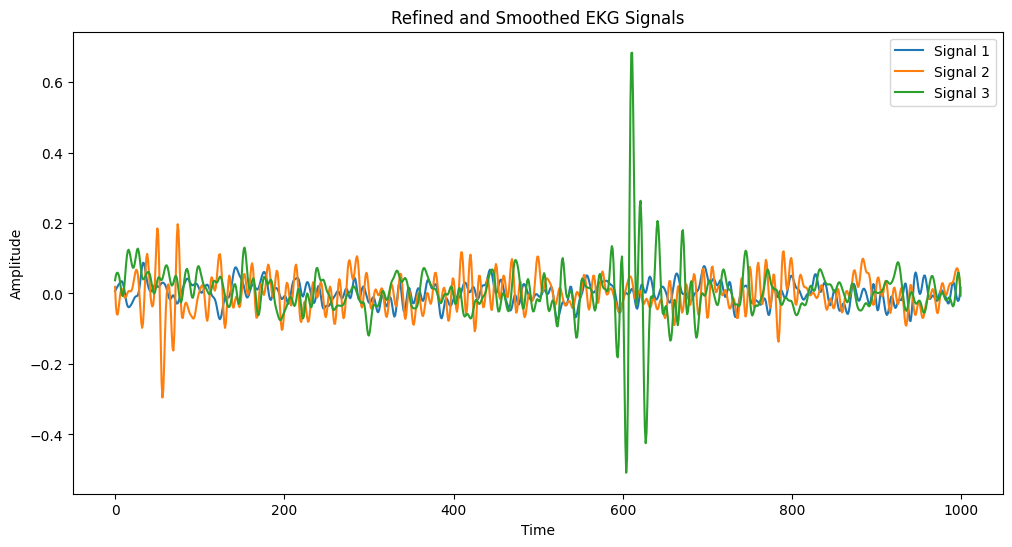

In [75]:
# Visualize first 3 signals after bandpass filter > bandpass filter > moving average > bandpass filter > savgolfilter
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(smoothed_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Refined and Smoothed EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [76]:
from scipy.signal import savgol_filter

smoothed_signals = [savgol_filter(signal, window_length=21, polyorder=3) for signal in filtered_signals]

In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_signals = [scaler.fit_transform(signal.reshape(-1, 1)).flatten() for signal in smoothed_signals]


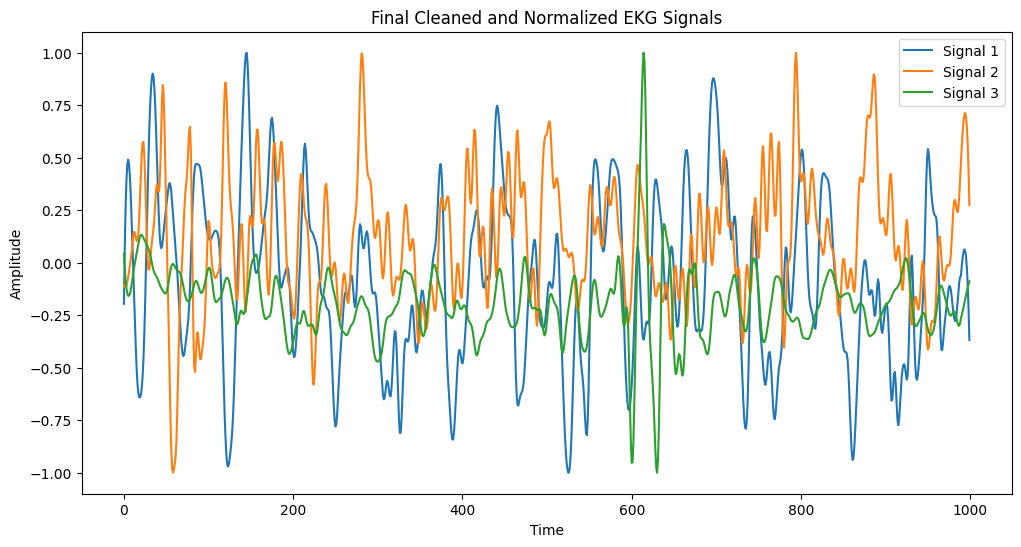

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(normalized_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Final Cleaned and Normalized EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


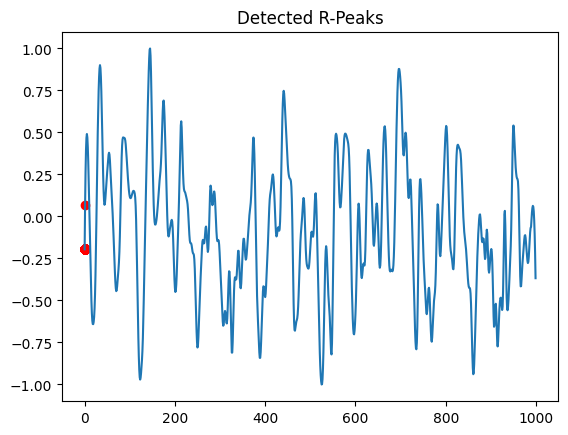

In [79]:
import neurokit2 as nk

rpeaks, _ = nk.ecg_peaks(normalized_signals[0], sampling_rate=360)
plt.plot(normalized_signals[0])
plt.scatter(rpeaks["ECG_R_Peaks"], normalized_signals[0][rpeaks["ECG_R_Peaks"]], color='red')
plt.title("Detected R-Peaks")
plt.show()


In [80]:
def bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, fs=360, order=4):
    nyquist = 0.5 * fs
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signal = bandpass_filter(normalized_signals[0], low_cutoff=0.5, high_cutoff=50, fs=360)


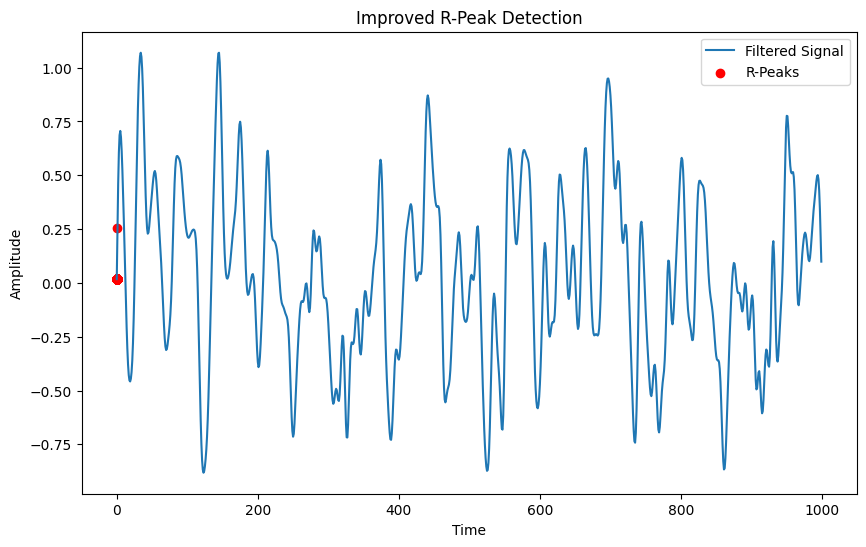

In [81]:
import neurokit2 as nk
import matplotlib.pyplot as plt

rpeaks, _ = nk.ecg_peaks(filtered_signal, sampling_rate=360)

plt.figure(figsize=(10, 6))
plt.plot(filtered_signal, label="Filtered Signal")
plt.scatter(rpeaks["ECG_R_Peaks"], filtered_signal[rpeaks["ECG_R_Peaks"]], color='red', label="R-Peaks")
plt.title("Improved R-Peak Detection")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_signal = scaler.fit_transform(filtered_signal.reshape(-1, 1)).flatten()


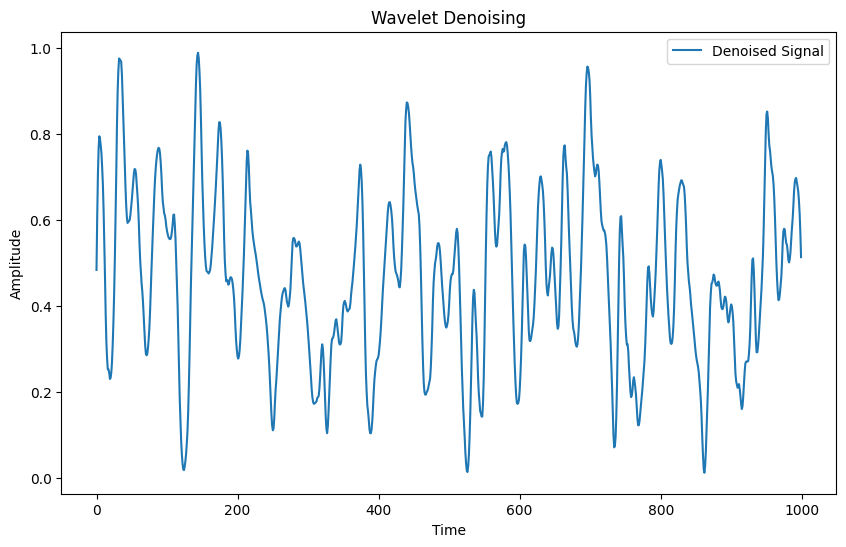

In [83]:
import pywt

def wavelet_denoise(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, np.std(c)/2, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

denoised_signal = wavelet_denoise(scaled_signal)

plt.figure(figsize=(10, 6))
plt.plot(denoised_signal, label="Denoised Signal")
plt.title("Wavelet Denoising")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


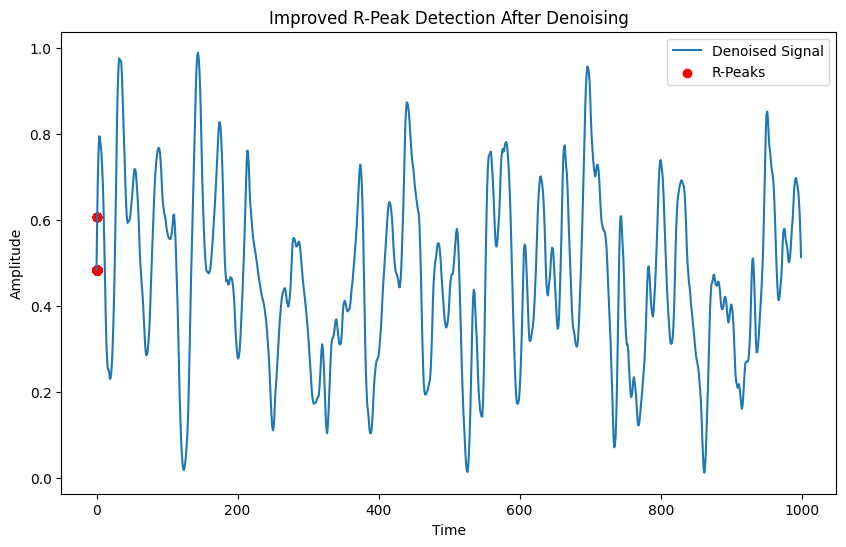

In [84]:
import neurokit2 as nk
import matplotlib.pyplot as plt

rpeaks, info = nk.ecg_peaks(denoised_signal, sampling_rate=360, method="pantompkins1985", correct_artifacts=True)

plt.figure(figsize=(10, 6))
plt.plot(denoised_signal, label="Denoised Signal")
plt.scatter(rpeaks["ECG_R_Peaks"], denoised_signal[rpeaks["ECG_R_Peaks"]], color='red', label="R-Peaks")
plt.title("Improved R-Peak Detection After Denoising")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


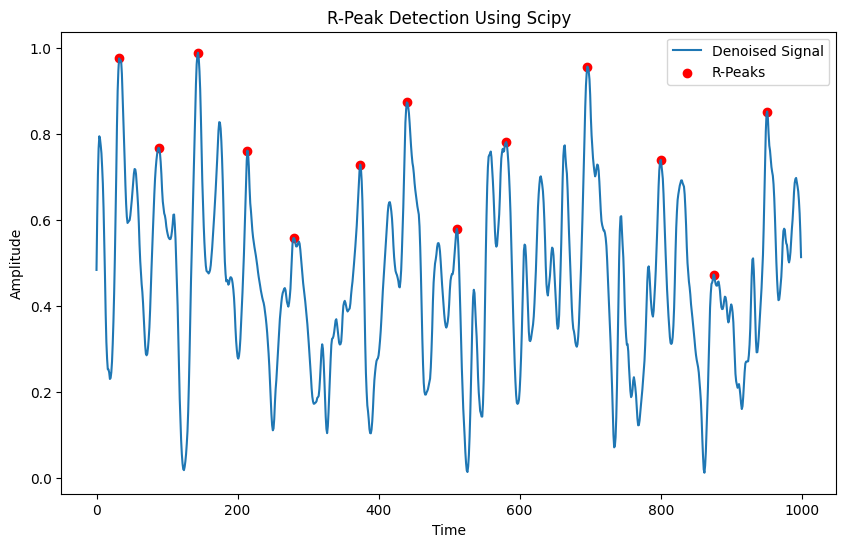

In [85]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

peaks, properties = find_peaks(denoised_signal, prominence=0.2, distance=50)

plt.figure(figsize=(10, 6))
plt.plot(denoised_signal, label="Denoised Signal")
plt.scatter(peaks, denoised_signal[peaks], color='red', label="R-Peaks")
plt.title("R-Peak Detection Using Scipy")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [86]:
print(f"Number of detected R-peaks: {len(peaks)}")

# compute RR intervals, convert to seconds from Hz
sampling_rate = 360
rr_intervals = np.diff(peaks) / sampling_rate 
print("RR Intervals (seconds):", rr_intervals)


Number of detected R-peaks: 13
RR Intervals (seconds): [0.15555556 0.15555556 0.19444444 0.18333333 0.26111111 0.18333333
 0.19722222 0.19444444 0.31944444 0.28888889 0.20833333 0.21111111]


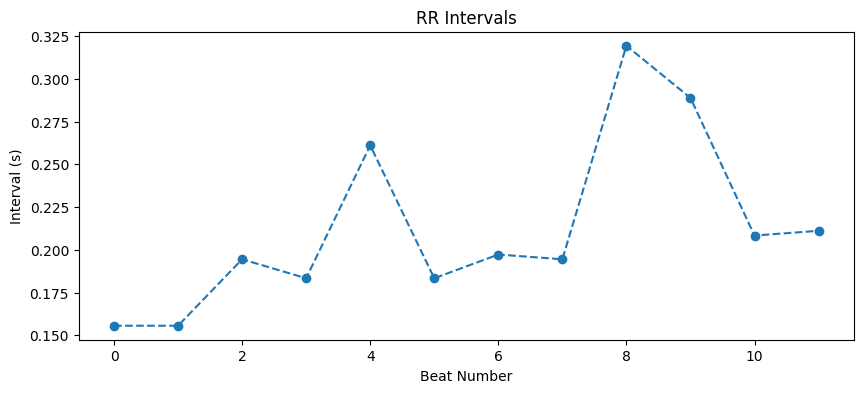

In [87]:
# visualize rr intervals (one r-peak to another)
plt.figure(figsize=(10, 4))
plt.plot(rr_intervals, marker='o', linestyle='--')
plt.title("RR Intervals")
plt.xlabel("Beat Number")
plt.ylabel("Interval (s)")
plt.show()


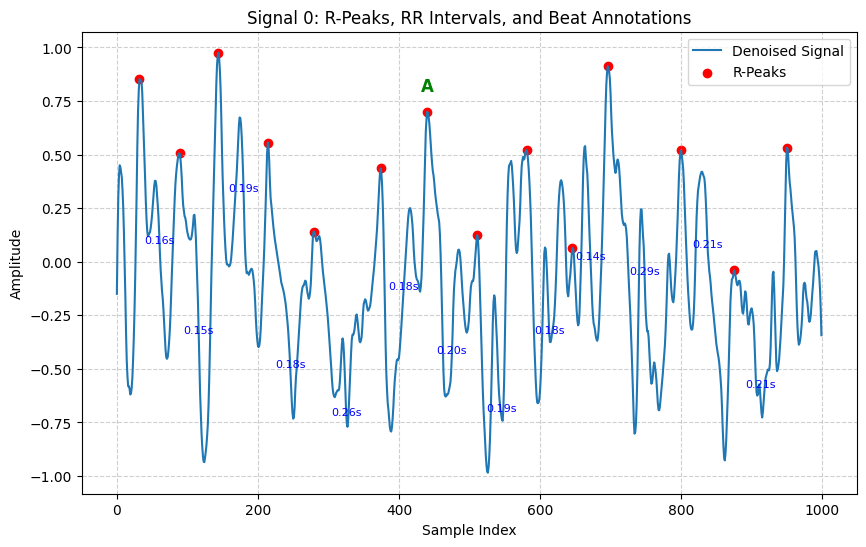

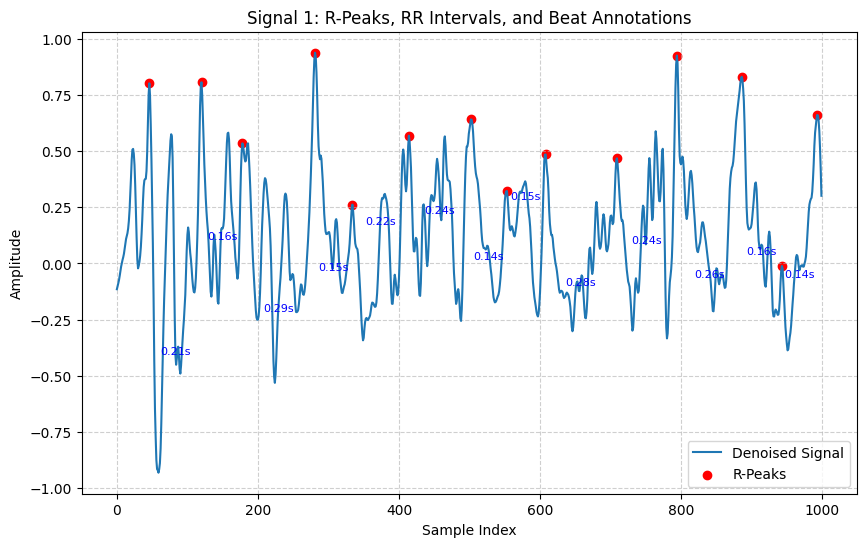

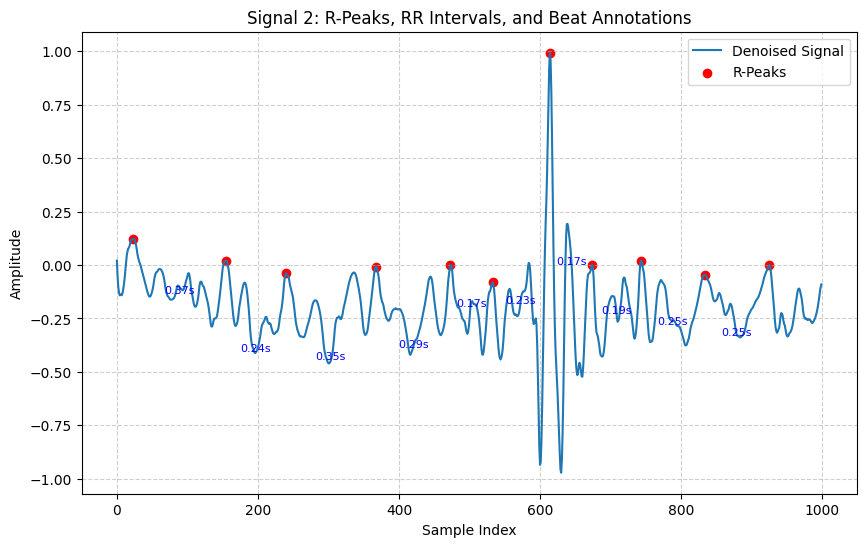

In [88]:
import matplotlib.pyplot as plt
import numpy as np

TOLERANCE_SAMPLES = 10 

for i, signal in enumerate(normalized_signals):
    denoised_signal = wavelet_denoise(signal)
    
    peaks, _ = find_peaks(denoised_signal, prominence=0.2, distance=50)
    annotation_map = standardized_annotations[i]
    
    rr_intervals = np.diff(peaks) / 360

    annotated_peaks = []
    annotated_symbols = []
    
    for j, peak_index in enumerate(peaks):
        beat_type = ''
        
        for ann_index, ann_symbol in annotation_map.items():
            if abs(peak_index - ann_index) <= TOLERANCE_SAMPLES:
                beat_type = ann_symbol
                break
        
        annotated_peaks.append(peak_index)
        annotated_symbols.append(beat_type)
        
        if j > 0:
            mid = (peaks[j-1] + peak_index) // 2
    
    if i < 3:
        plt.figure(figsize=(10, 6))
        
        plt.plot(denoised_signal, label="Denoised Signal")
        plt.scatter(peaks, denoised_signal[peaks], color='red', label="R-Peaks")

        for j in range(len(peaks) - 1):
            mid = (peaks[j] + peaks[j+1]) // 2
            plt.text(mid, denoised_signal[mid] * 0.9, f"{rr_intervals[j]:.2f}s", color="blue", fontsize=8, ha='center', va='top')
            
        for peak_index, symbol in zip(annotated_peaks, annotated_symbols):
            if symbol and symbol not in ['N', '·']:
                plt.annotate(symbol, (peak_index, denoised_signal[peak_index]), textcoords="offset points", xytext=(0, 15), ha='center', color='green', fontsize=12, fontweight='bold')
                
        plt.title(f"Signal {i}: R-Peaks, RR Intervals, and Beat Annotations")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

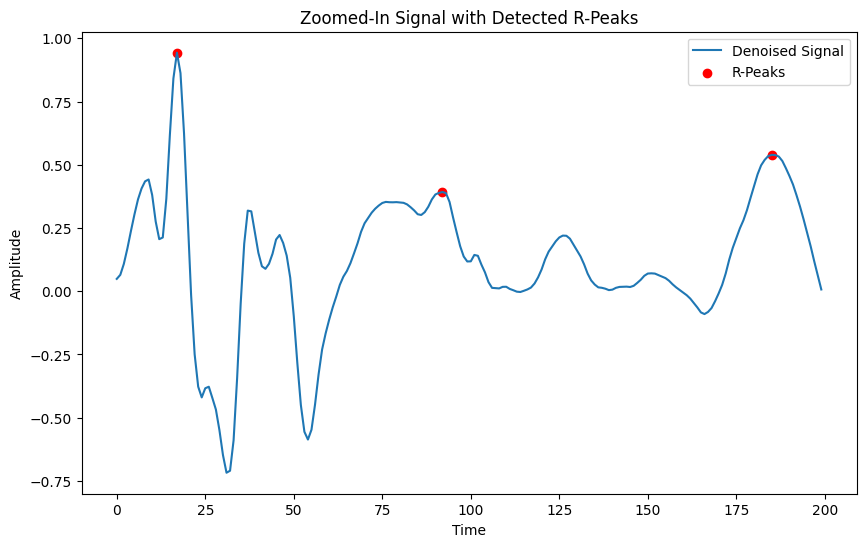

In [89]:
# zoom in on a desired range
START, END = 200, 400

plt.figure(figsize=(10, 6))
plt.plot(denoised_signal[START:END], label="Denoised Signal")
plt.scatter(peaks[(peaks > START) & (peaks < END)] - START,
            denoised_signal[peaks[(peaks > START) & (peaks < END)]],
            color='red', label="R-Peaks")
plt.title("Zoomed-In Signal with Detected R-Peaks")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


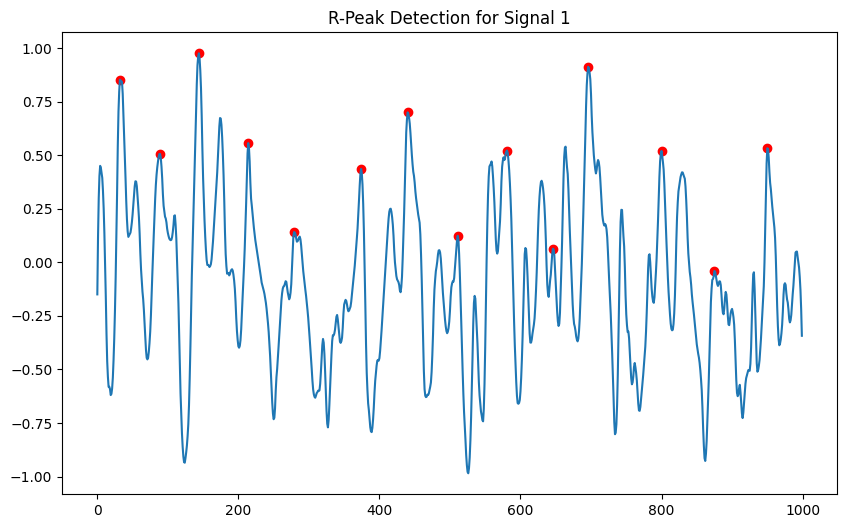

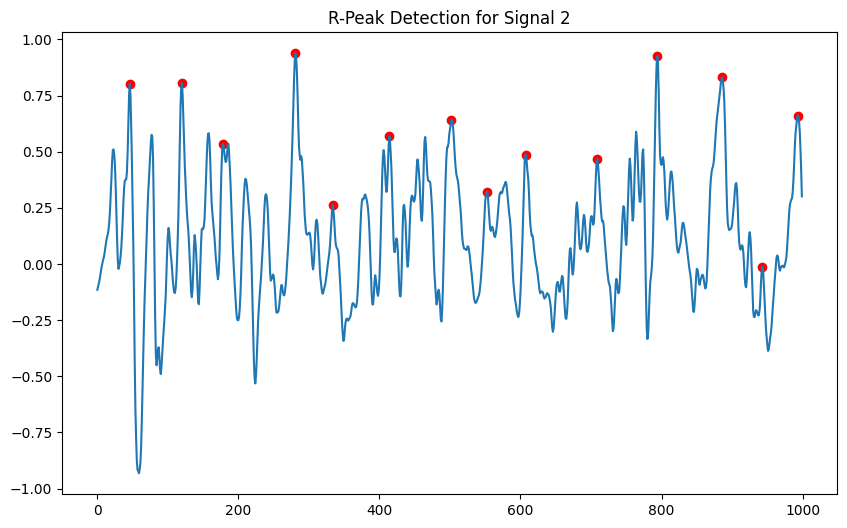

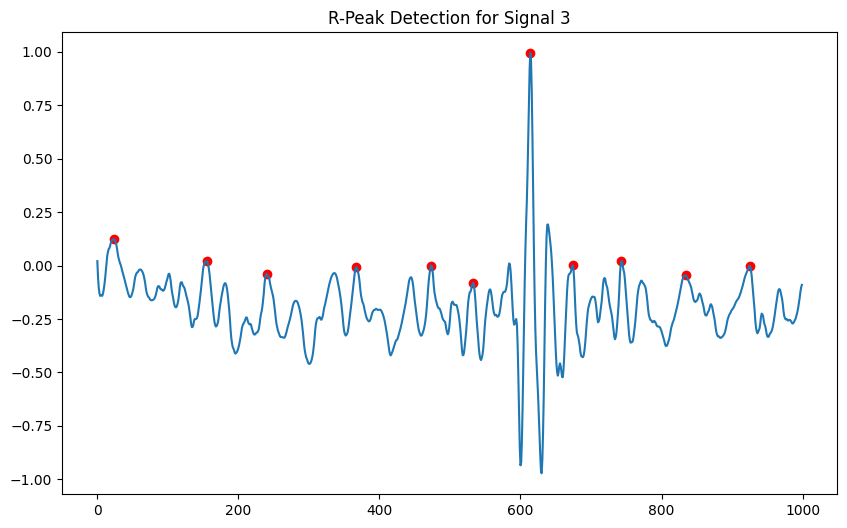

Total individual beats processed and classified: 496


In [90]:
import numpy as np

TOLERANCE_SAMPLES = 10

all_beat_features = []

for i, signal in enumerate(normalized_signals):
    denoised_signal = wavelet_denoise(signal)
    
    peaks, _ = find_peaks(denoised_signal, prominence=0.2, distance=50)
    
    annotation_map = standardized_annotations[i]
    
    for j, peak_index in enumerate(peaks):
        if j == 0:
            continue

        prev_peak_index = peaks[j-1]
        
        rr_interval_ms = (peak_index - prev_peak_index) / 360 * 1000 
        
        beat_type = 'Unclassified'
        
        for ann_index, ann_symbol in annotation_map.items():
            
            if abs(peak_index - ann_index) <= TOLERANCE_SAMPLES:
                beat_type = ann_symbol
                break

        beat_feature = {
            "EKG_ID": ekg_id,
            "R_Peak_Index": peak_index,
            "RR_Interval_ms": rr_interval_ms,
            "Beat_Type": beat_type,
        }
        all_beat_features.append(beat_feature)


    if i < 3:
        plt.figure(figsize=(10, 6))
        plt.plot(denoised_signal)
        plt.scatter(peaks, denoised_signal[peaks], color='red')
        plt.title(f"R-Peak Detection for Signal {i+1}")
        plt.show()

print(f"Total individual beats processed and classified: {len(all_beat_features)}")

In [93]:

all_rr_intervals = []
all_features = []

# denoise signal, detect r-peaks with scipy, compute rr intervals and hrv metrics
# attach annotations for normal/abnormal
# plot first 3 signals
for i, signal in enumerate(normalized_signals):
    denoised_signal = wavelet_denoise(signal)

    peaks, _ = find_peaks(denoised_signal, prominence=0.2, distance=50)

    rr_intervals = np.diff(peaks) / 360
    all_rr_intervals.append(rr_intervals)

    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals) * 100
    
    annotations = ekg_records[i].annotations
    features = {
        "Signal Index": i,
        "Mean RR": mean_rr,
        "SDNN": sdnn,
        "RMSSD": rmssd,
        "pNN50": pnn50,
        "annotations": annotations
    }
    all_features.append(features)



In [94]:
# save features to a CSV file
import pandas as pd

features_df = pd.DataFrame(all_features)
features_df.to_csv("ekg_features.csv", index=False)

# save RR intervals for each signal
rr_intervals_dict = {f"Signal_{i}": rr for i, rr in enumerate(all_rr_intervals)}
np.save("rr_intervals.npy", rr_intervals_dict)

print("Features and RR intervals saved!")


Features and RR intervals saved!
